### IS4242 Group 8 Project

### Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

import nltk
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE

nltk.download("punkt")

from textblob import TextBlob
from spacy.lang.de.stop_words import STOP_WORDS

from scipy import spatial
import gensim.downloader as api
import time
import copy
import pickle

%matplotlib inline
plt.style.use('ggplot')
sns.set_theme()

pd.set_option('display.max_colwidth', None)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\edmun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Constants

TARGET_VARS = ["hate", "privacy", "sexual",
               "impersonation", "illegal", "advertisement", "ai"]
RANDOM_STATE = 420

### Exploring the processed dataset

In [4]:
df = pd.read_csv('data/df_combined_processed_no_reddit_title_no_stem_no_lemma_2023-04-02.csv')
df

,body,hate,privacy,sexual,impersonation,illegal,advertisement,ai
0,kalleron design refuse collection recycling sites hear huge demand nowadays,0,0,0,0,0,0,0
1,hotmeringue2880 hi economics graduate years experience risk analyst looking make career shift people community development management suggest good mentors connect get clarity navigate shift,0,0,0,0,0,0,0
2,milenakowalska hey year finish bachelor degree informatics still sure next thinking master bioinformatics cannot find affordable option looking distance learning opportunities experience shown much easier combine full time job currently working software engineer interested natural sciences like biology physics mathematics especially theoretical maths economics banking etc also would like choose something specific informatics master like become expert area anyone ideas,0,0,0,0,0,0,0
3,rstonerphd studying makes employees want leave jobs impact employees ability leave new job study look employees want stay well survey less min complete individuals remain anonymous httpswwwsurveymonkeycomr5ppcvt5httpswwwsurveymonkeycomr5ppcvt5,0,0,0,0,0,1,0
4,temporarysection50 hi accepted job offer earlier month supervisor administrative staff ie receptionist assistants mail room clerks etc lead prior job aka right hand lady manager supervise staff members manager sick vacation rare supervisors keep morale positivewelcoming environment keep staff motivated supervisors amazing ones supervisor done make happy work environment anything helps thank,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
41198,yous muthafin lie 8220lifeasking 20pearls coreyemanuel right tl trash 8230 mine bible scriptures hymns8221,1,0,0,0,0,0,0
41199,youve gone broke wrong heart baby drove redneck crazy,0,0,0,0,0,0,0
41200,young buck wanna eat dat nigguh like aint fuckin dis,1,0,0,0,0,0,0
41201,youu got wild bitches tellin lies,1,0,0,0,0,0,0


### Target Class Exploration

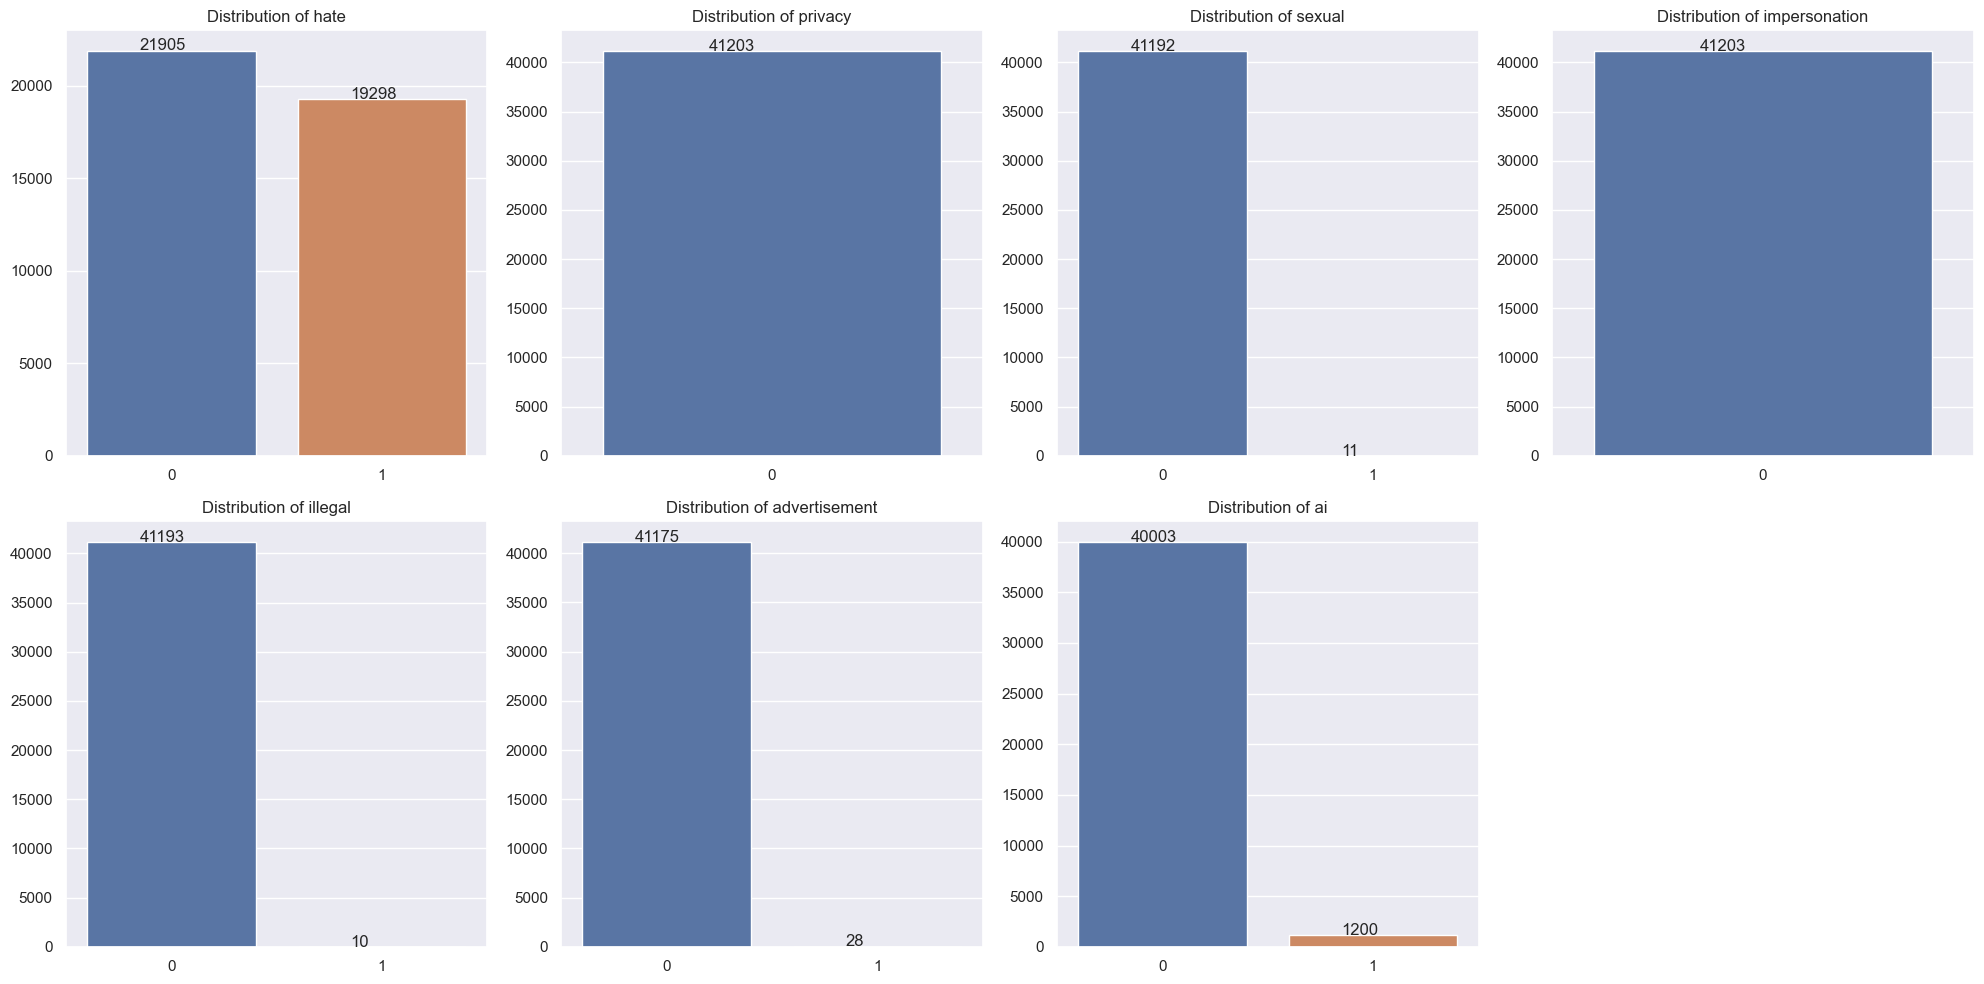

In [4]:
# Plotting the distribution of the target variables

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in enumerate(axes.flatten()):
    if i < 7:
        sns.countplot(data=df, x=TARGET_VARS[i], ax=ax)
        ax.set_title(f'Distribution of {TARGET_VARS[i]}')
        ax.set_xlabel('')
        ax.set_ylabel('')
        # add counts to the bars
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}',
                        (p.get_x()+0.25, p.get_height()+13))

    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

### Textual Exploration

#### N-Gram Analysis

In [5]:
# Calculating frequencies of n-grams

def n_gram_frequencies(text, n):

    # Splitting text into words
    words = str(text).split()

    # Creating n-grams
    n_grams = zip(*[words[i:] for i in range(n)])

    # Calculating frequencies
    n_gram_freq = {}
    for n_gram in n_grams:
        n_gram = " ".join(n_gram)
        if n_gram in n_gram_freq:
            n_gram_freq[n_gram] += 1
        else:
            n_gram_freq[n_gram] = 1

    return n_gram_freq


def combine_n_gram_dicts_row_wise(n_gram_dict, combined_dict):
    for key, value in n_gram_dict.items():
        if key in combined_dict:
            combined_dict[key] += value
        else:
            combined_dict[key] = value
    return n_gram_dict


def generate_n_gram_dicts(df):
    all_data_1_gram = {}
    all_data_2_gram = {}
    all_data_3_gram = {}
    df["n-grams_1"].apply(lambda x: combine_n_gram_dicts_row_wise(x,
                          all_data_1_gram))
    df["n-grams_2"].apply(lambda x: combine_n_gram_dicts_row_wise(x,
                          all_data_2_gram))
    df["n-grams_3"].apply(lambda x: combine_n_gram_dicts_row_wise(x,
                          all_data_3_gram))
    return all_data_1_gram, all_data_2_gram, all_data_3_gram


def convert_dict_to_df(word_frequencies, min_freq=1):
    word_frequencies_df = pd.DataFrame.from_dict(
        word_frequencies, orient='index', columns=['Frequency'])
    word_frequencies_df = word_frequencies_df.sort_values(
        by='Frequency', ascending=False)
    word_frequencies_df = word_frequencies_df.reset_index().rename(columns={
        'index': 'Word'})
    word_frequencies_df = word_frequencies_df[word_frequencies_df['Frequency'] >= min_freq]
    return word_frequencies_df


def generate_wordcloud_from_freq(word_frequencies, var):
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=word_frequencies)
    # Display the generated image:
    fig, ax = plt.subplots(figsize=(16, 20))
    ax.imshow(wordcloud)
    plt.axis("off")
    plt.title(f"Word Cloud for {var}", fontsize=20)
    plt.show()


def generate_n_gram_analysis(df):
    for i in range(1, 4):
        df[f"n-grams_{i}"] = df["body"].apply(
            lambda x: n_gram_frequencies(x, i))

    # all data
    print("All Data")
    all_data_1_gram, all_data_2_gram, all_data_3_gram = generate_n_gram_dicts(
        df)
    print("All Data - 1-gram")
    display(convert_dict_to_df(all_data_1_gram).head(15))
    generate_wordcloud_from_freq(all_data_1_gram, "All Data - 1-gram")
    print("All Data - 2-gram")
    display(convert_dict_to_df(all_data_2_gram).head(15))
    generate_wordcloud_from_freq(all_data_2_gram, "All Data - 2-gram")
    print("All Data - 3-gram")
    display(convert_dict_to_df(all_data_3_gram).head(15))
    generate_wordcloud_from_freq(all_data_3_gram, "All Data - 3-gram")

    for var in TARGET_VARS:

        var_df = df[df[var] == 1]
        print(f"{var} data")
        var_1_gram, var_2_gram, var_3_gram = generate_n_gram_dicts(var_df)
        if var_1_gram:
            print(f"{var} data - 1-gram")
            display(convert_dict_to_df(var_1_gram).head(15))
            generate_wordcloud_from_freq(var_1_gram, f"{var} data - 1-gram")
        else:
            print(f"No 1-gram data for {var}. \n")

        if var_2_gram:
            print(f"{var} data - 2-gram")
            display(convert_dict_to_df(var_2_gram).head(15))
            generate_wordcloud_from_freq(var_2_gram, f"{var} data - 2-gram")
        else:
            print(f"No 2-gram data for {var}. \n")

        if var_3_gram:
            print(f"{var} data - 3-gram")
            display(convert_dict_to_df(var_3_gram).head(15))
            generate_wordcloud_from_freq(var_3_gram, f"{var} data - 3-gram")
        else:
            print(f"No 3-gram data for {var}. \n")

        print("=================================================================================================")

All Data
All Data - 1-gram


,Word,Frequency
0,bitch,8132
1,rt,7582
2,like,5872
3,im,3701
4,get,3376
5,bitches,3046
6,dont,2965
7,one,2668
8,hoes,2335
9,time,2142


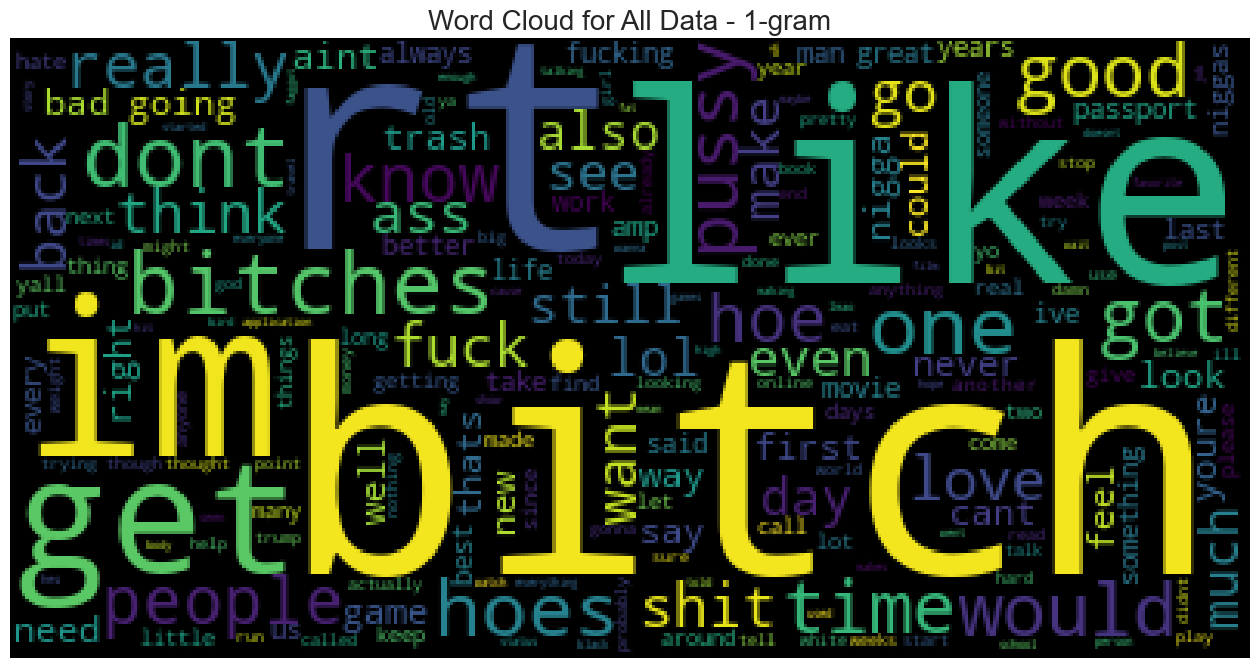

All Data - 2-gram


,Word,Frequency
0,feel like,333
1,look like,271
2,dont know,242
3,bitch ass,234
4,looks like,224
5,like bitch,208
6,yo bitch,189
7,ass bitch,184
8,bad bitch,176
9,bitch im,148


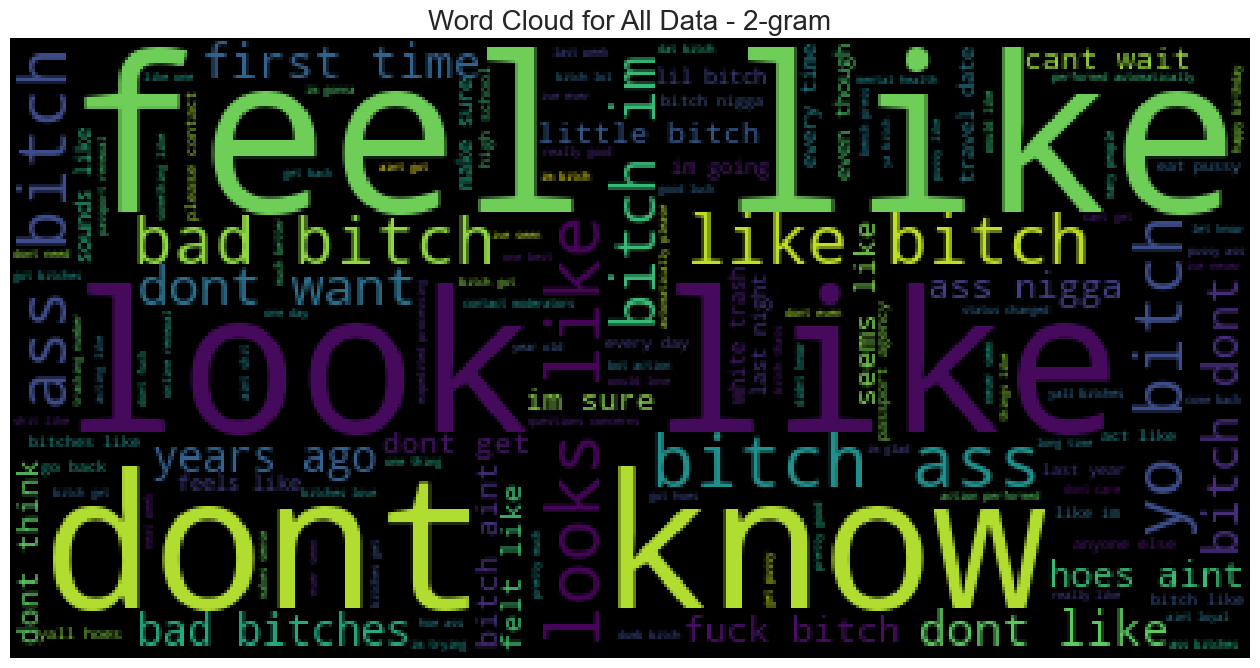

All Data - 3-gram


,Word,Frequency
0,automatically please contact,81
1,bot action performed,81
2,please contact moderators,81
3,performed automatically please,81
4,action performed automatically,81
5,hoes aint loyal,64
6,bitch ass nigga,53
7,violations result permanent,47
8,shill troll accusations,47
9,accusations hate speech,47


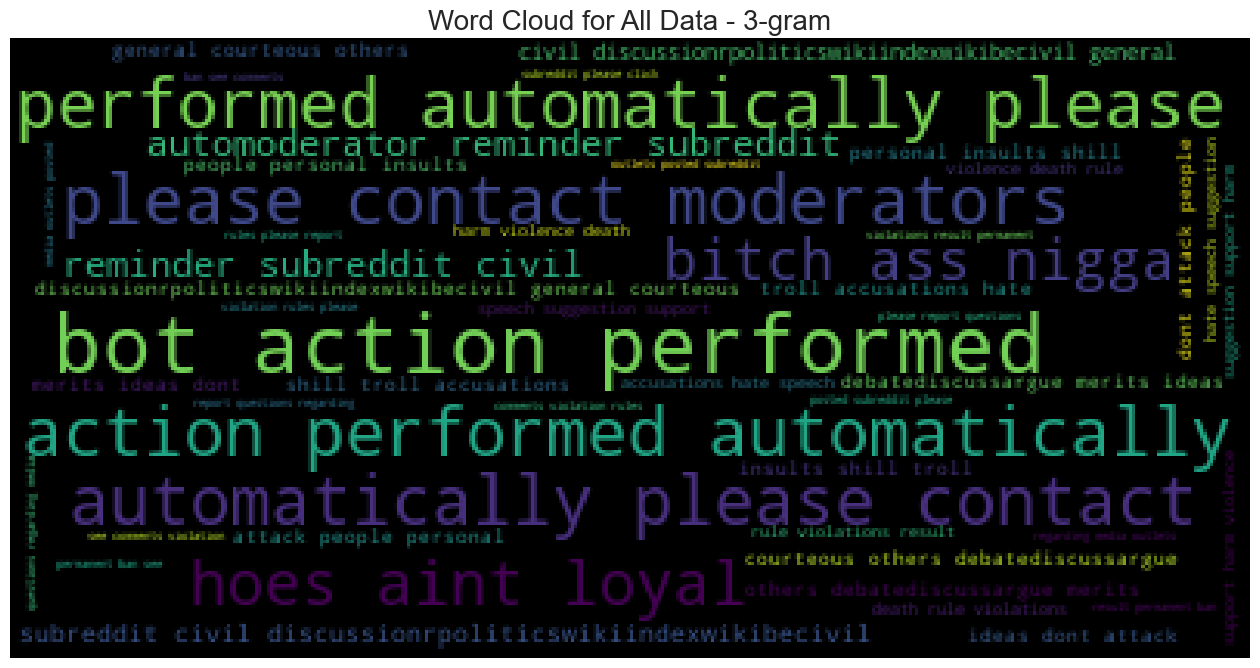

hate data
hate data - 1-gram


,Word,Frequency
0,bitch,7904
1,rt,5943
2,bitches,2989
3,like,2303
4,hoes,2266
5,pussy,2019
6,hoe,1794
7,im,1753
8,dont,1492
9,ass,1426


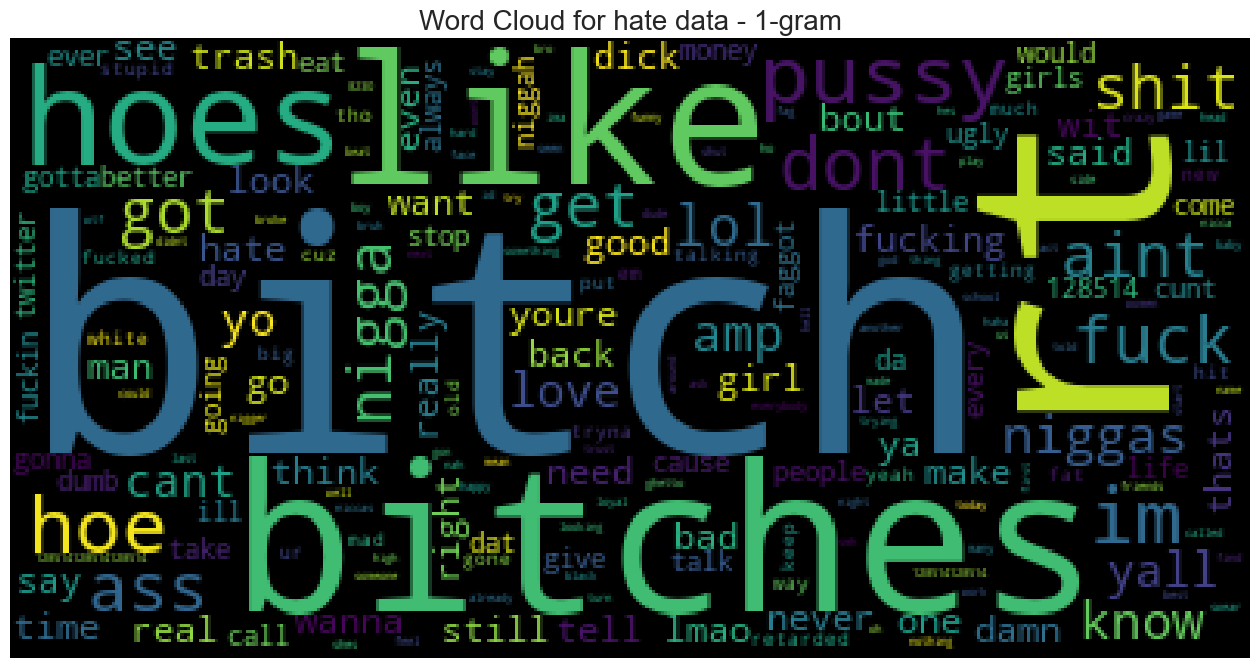

hate data - 2-gram


,Word,Frequency
0,bitch ass,220
1,like bitch,199
2,yo bitch,185
3,ass bitch,177
4,bad bitch,175
5,look like,152
6,bitch im,144
7,bad bitches,140
8,bitch dont,136
9,hoes aint,124


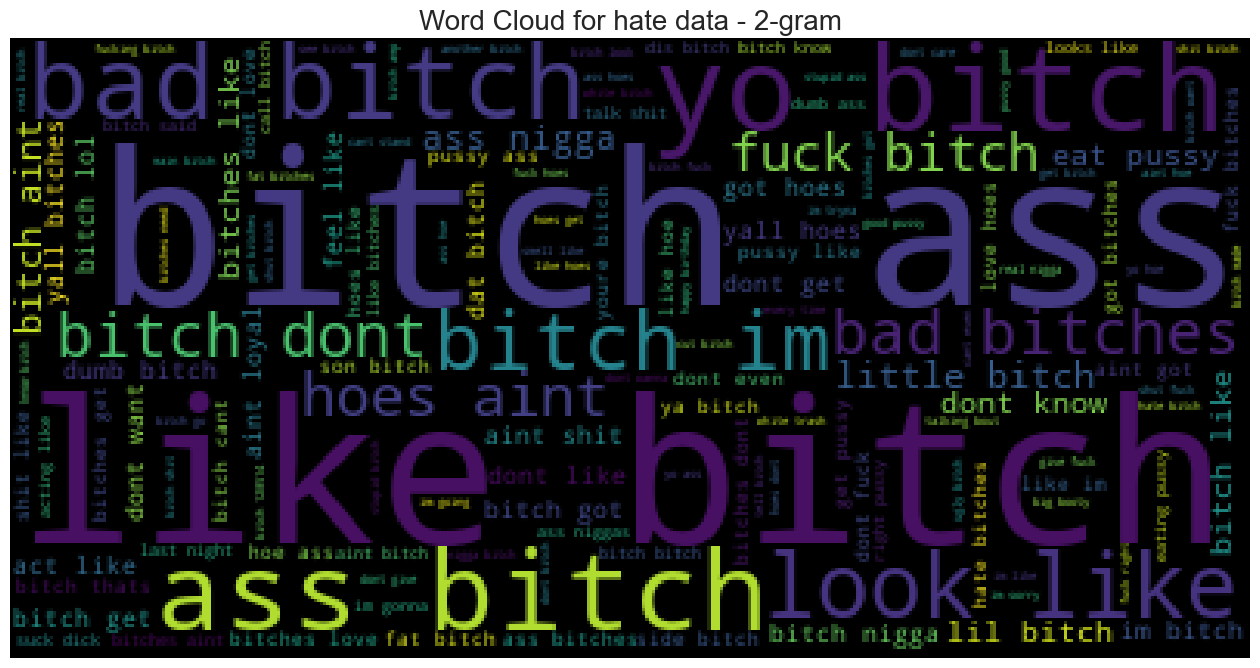

hate data - 3-gram


,Word,Frequency
0,hoes aint loyal,64
1,bitch ass nigga,46
2,dont love hoes,31
3,bitch look like,24
4,fuck right pussy,23
5,stupid ass bitch,23
6,yo bitch ass,22
7,bitches thing like,21
8,bad bitches thing,20
9,ass bitch aint,19


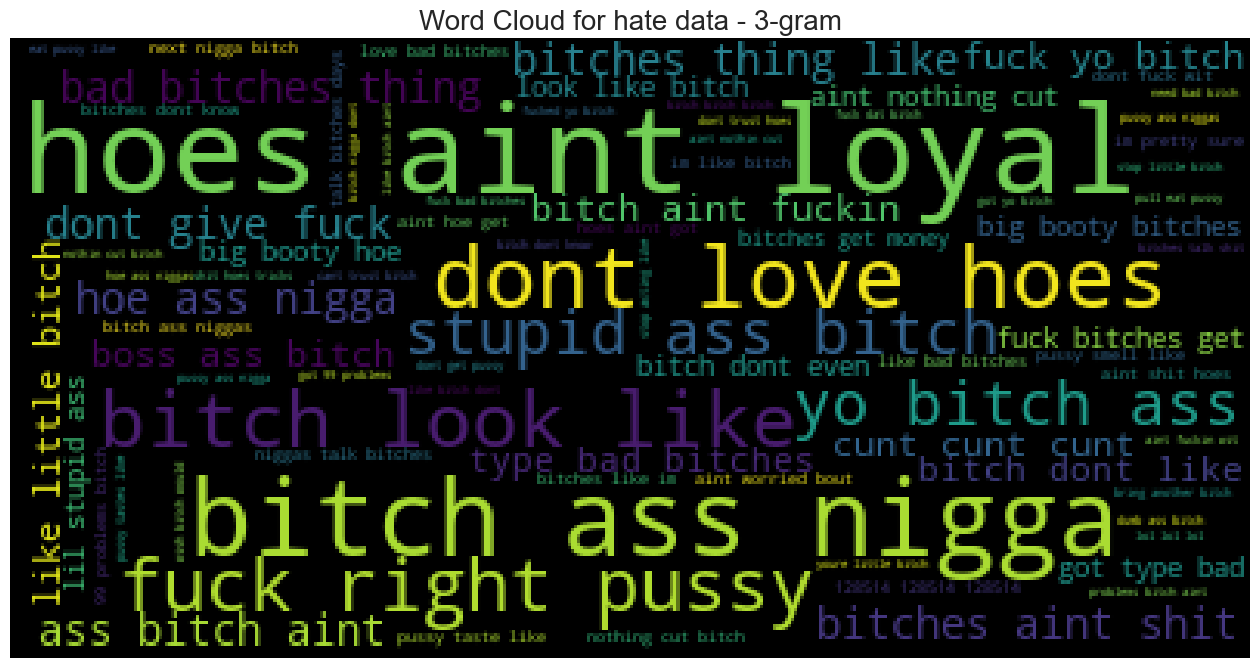

privacy data
No 1-gram data for privacy. 

No 2-gram data for privacy. 

No 3-gram data for privacy. 

sexual data
sexual data - 1-gram


,Word,Frequency
0,good,8
1,sex,6
2,story,6
3,romance,6
4,adult,6
5,new,6
6,fantasy,4
7,like,4
8,im,4
9,feel,4


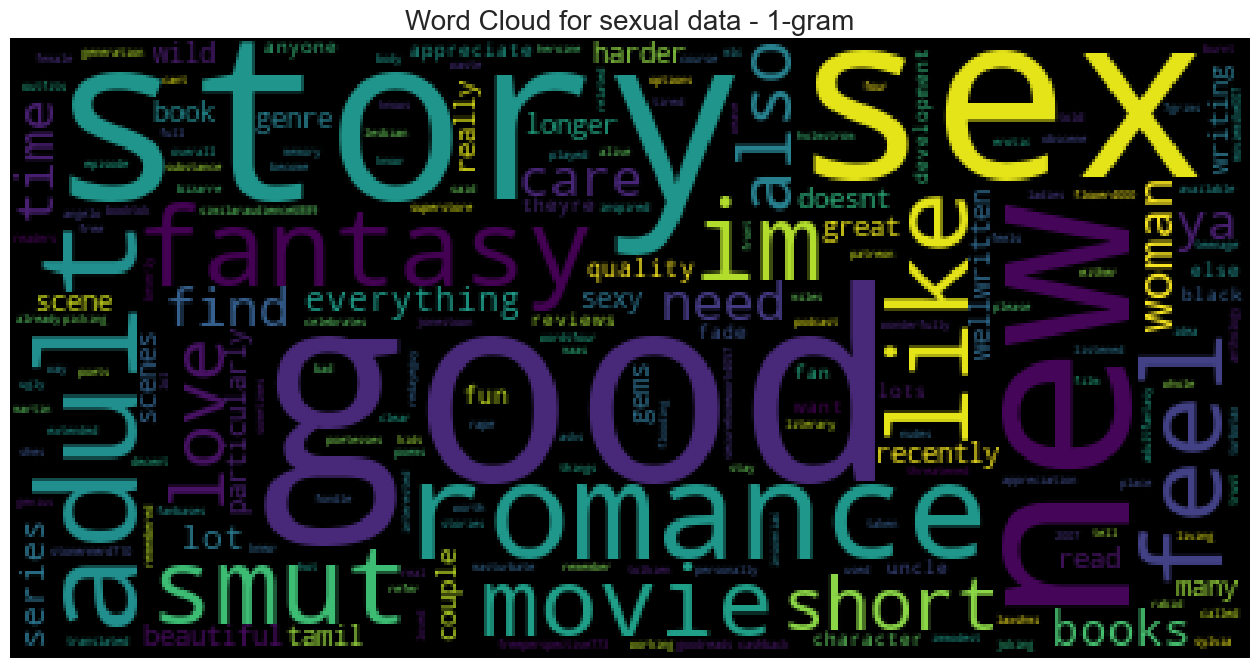

sexual data - 2-gram


,Word,Frequency
0,new adult,4
1,feel like,3
2,fade black,2
3,anyone else,2
4,else feel,2
5,appreciate good,2
6,like ya,2
7,ya sex,2
8,woman appreciate,2
9,fun woman,2


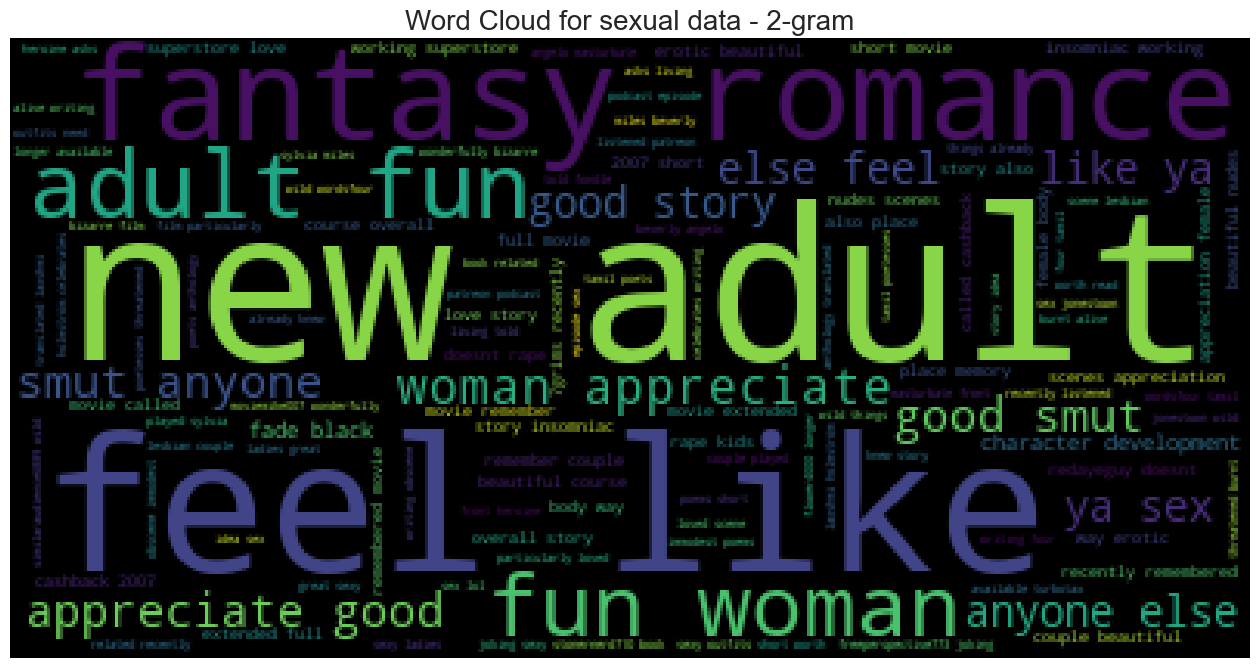

sexual data - 3-gram


,Word,Frequency
0,fun woman appreciate,2
1,like ya sex,2
2,feel like ya,2
3,else feel like,2
4,anyone else feel,2
5,smut anyone else,2
6,good smut anyone,2
7,appreciate good smut,2
8,woman appreciate good,2
9,adult fun woman,2


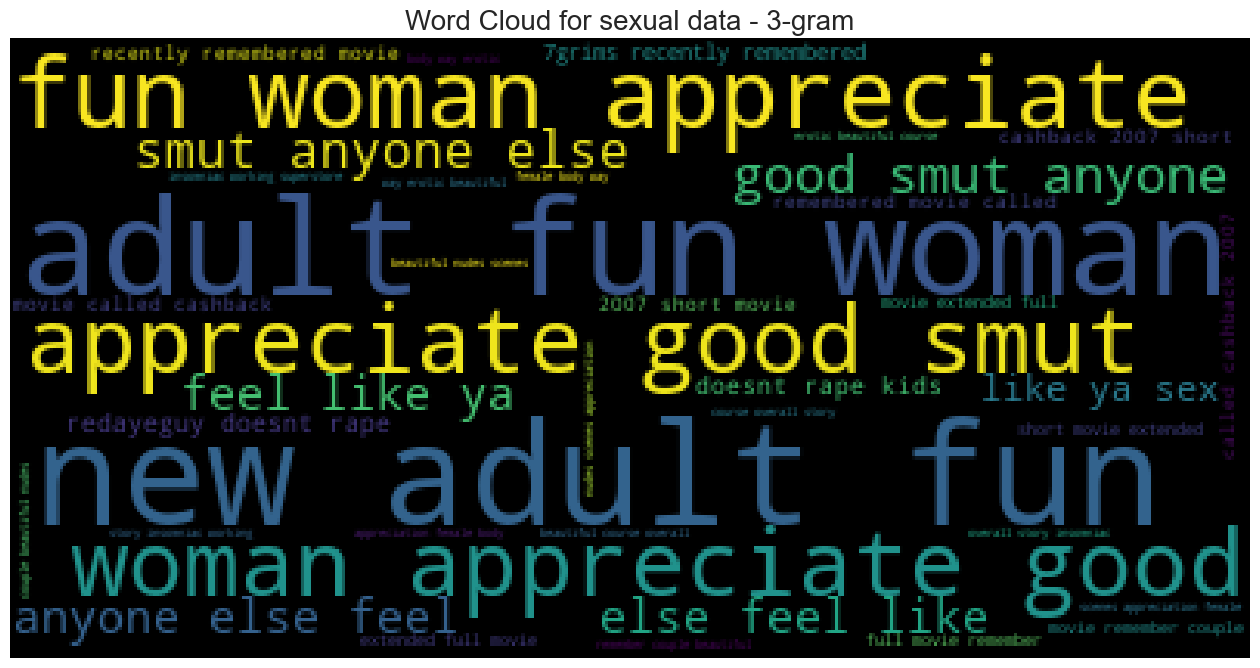

impersonation data
No 1-gram data for impersonation. 

No 2-gram data for impersonation. 

No 3-gram data for impersonation. 

illegal data
illegal data - 1-gram


,Word,Frequency
0,fuck,3
1,pedo,3
2,shit,3
3,fix,3
4,around,2
5,like,2
6,distributing,1
7,child,1
8,luckiest,1
9,guy,1


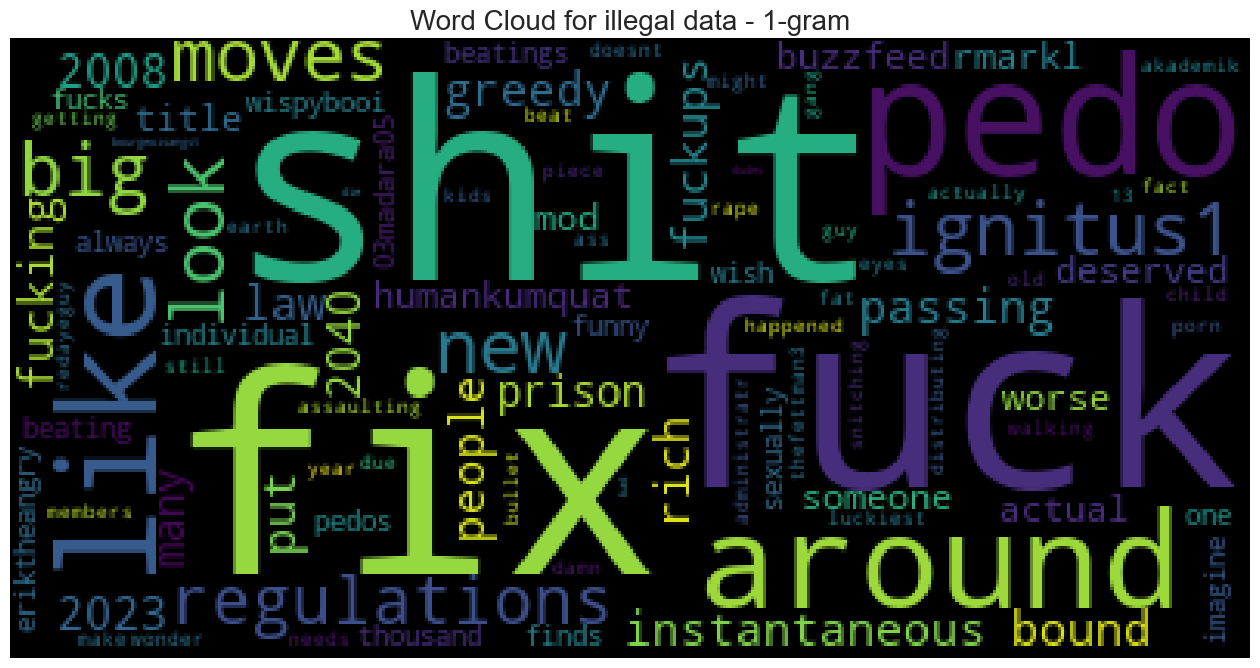

illegal data - 2-gram


,Word,Frequency
0,ignitus1 look,1
1,snitching gang,1
2,might actually,1
3,happened might,1
4,fact happened,1
5,like fact,1
6,around like,1
7,walking around,1
8,still walking,1
9,members still,1


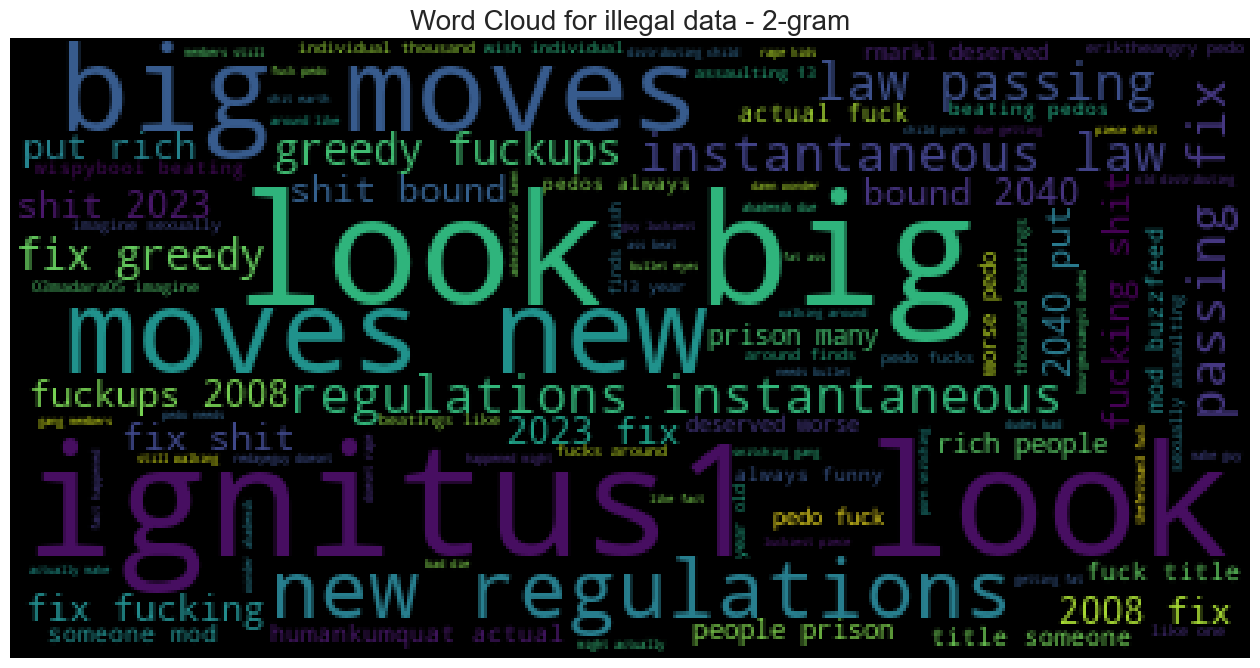

illegal data - 3-gram


,Word,Frequency
0,ignitus1 look big,1
1,porn snitching gang,1
2,fact happened might,1
3,like fact happened,1
4,around like fact,1
5,walking around like,1
6,still walking around,1
7,members still walking,1
8,gang members still,1
9,snitching gang members,1


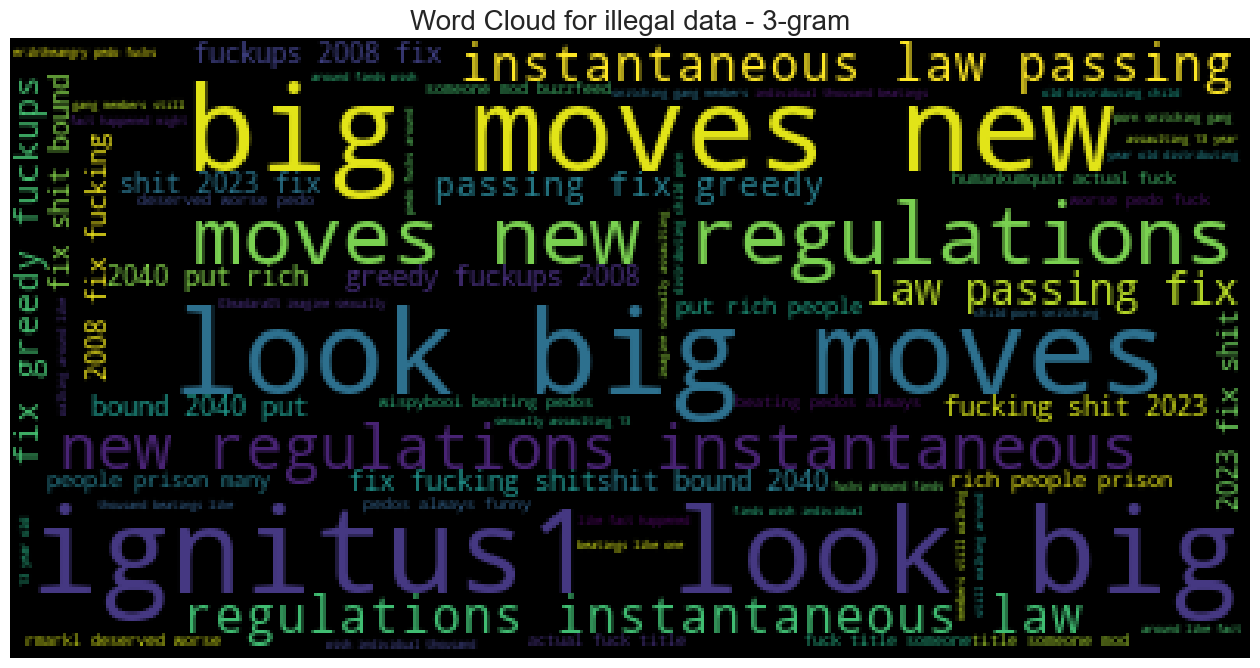

advertisement data
advertisement data - 1-gram


,Word,Frequency
0,pandabuy,47
1,taobao,30
2,shipping,29
3,career,24
4,use,24
5,dhl,24
6,x200b,24
7,haul,21
8,parcel,20
9,help,20


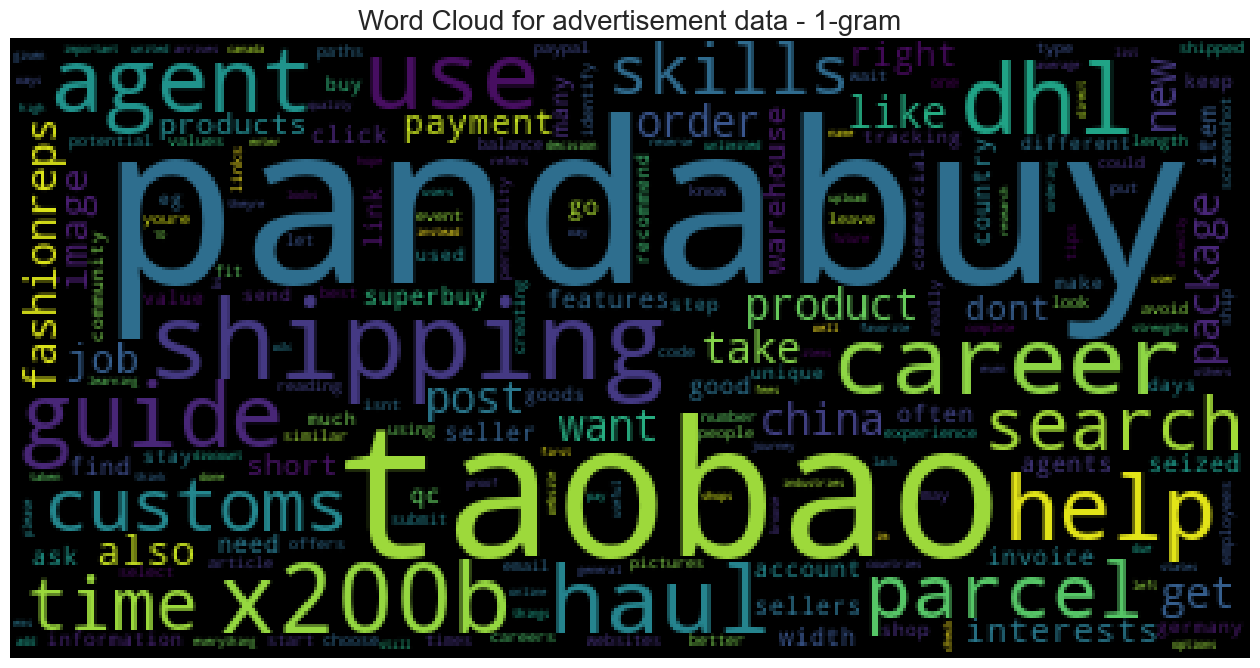

advertisement data - 2-gram


,Word,Frequency
0,commercial invoice,8
1,pandabuy guide,7
2,china post,6
3,often times,6
4,unique features,6
5,career paths,5
6,proof payment,5
7,image search,5
8,interests skills,4
9,reverse image,4


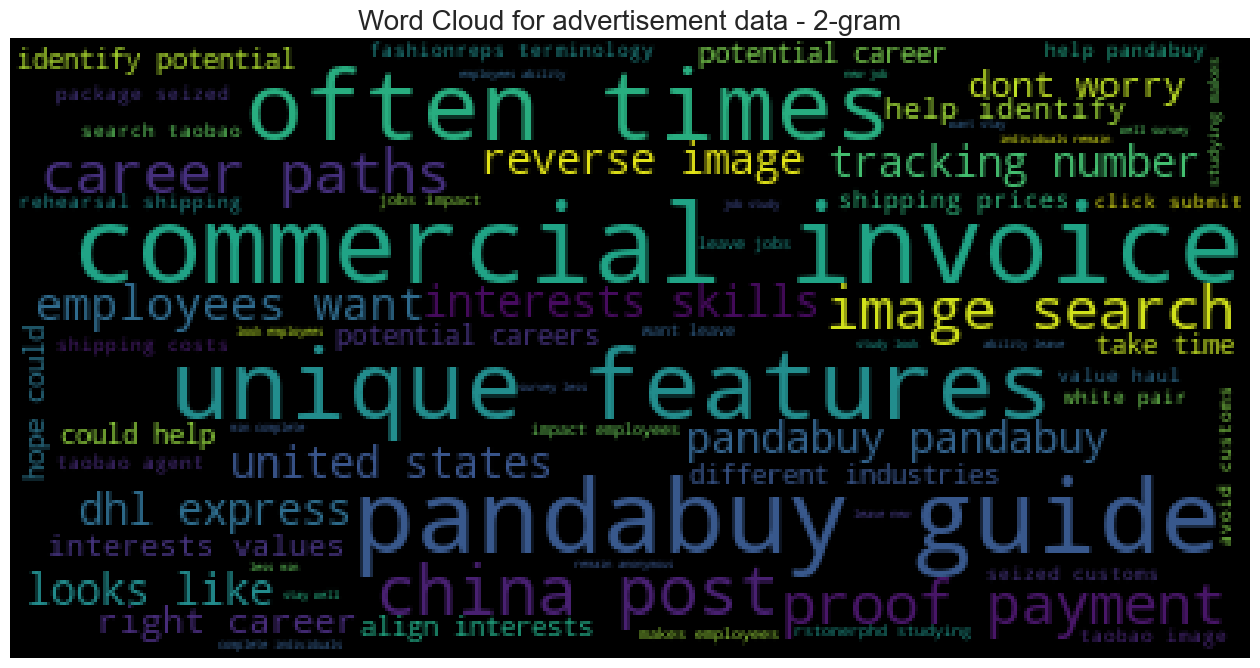

advertisement data - 3-gram


,Word,Frequency
0,reverse image search,4
1,potential career paths,3
2,hope could help,3
3,help identify potential,3
4,image search taobao,3
5,make haul cheaper,2
6,express hotline ask,2
7,hotline ask email,2
8,ask email proof,2
9,email proof payment,2


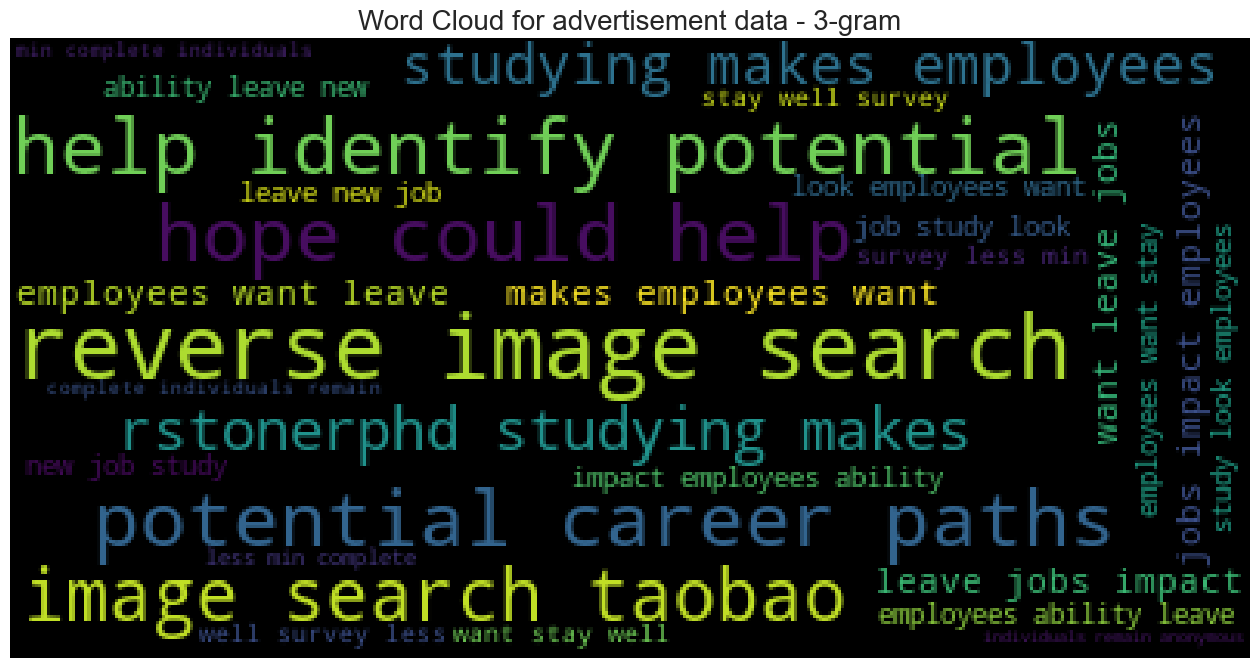

ai data
ai data - 1-gram


,Word,Frequency
0,im,109
1,love,103
2,new,91
3,favorite,86
4,life,85
5,cant,84
6,time,71
7,feeling,61
8,like,59
9,good,53


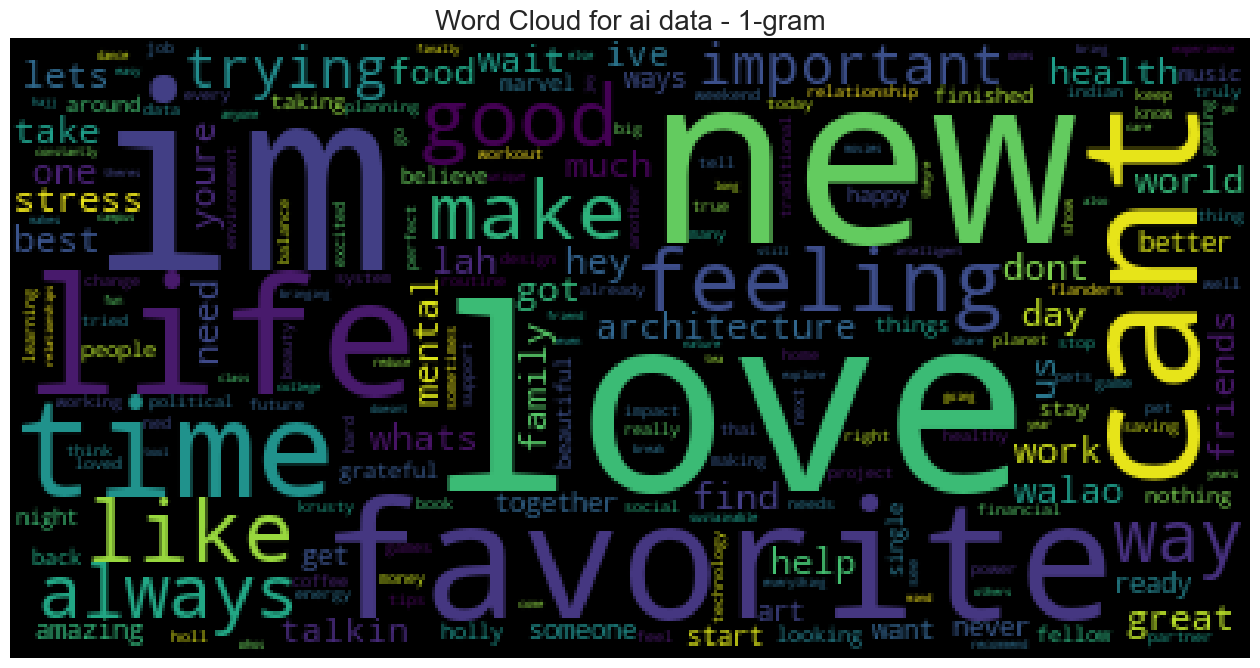

ai data - 2-gram


,Word,Frequency
0,cant wait,32
1,mental health,27
2,whats favorite,22
3,cant believe,17
4,trying new,16
5,holly holl,15
6,great way,15
7,ned flanders,15
8,im always,14
9,intelligent system,13


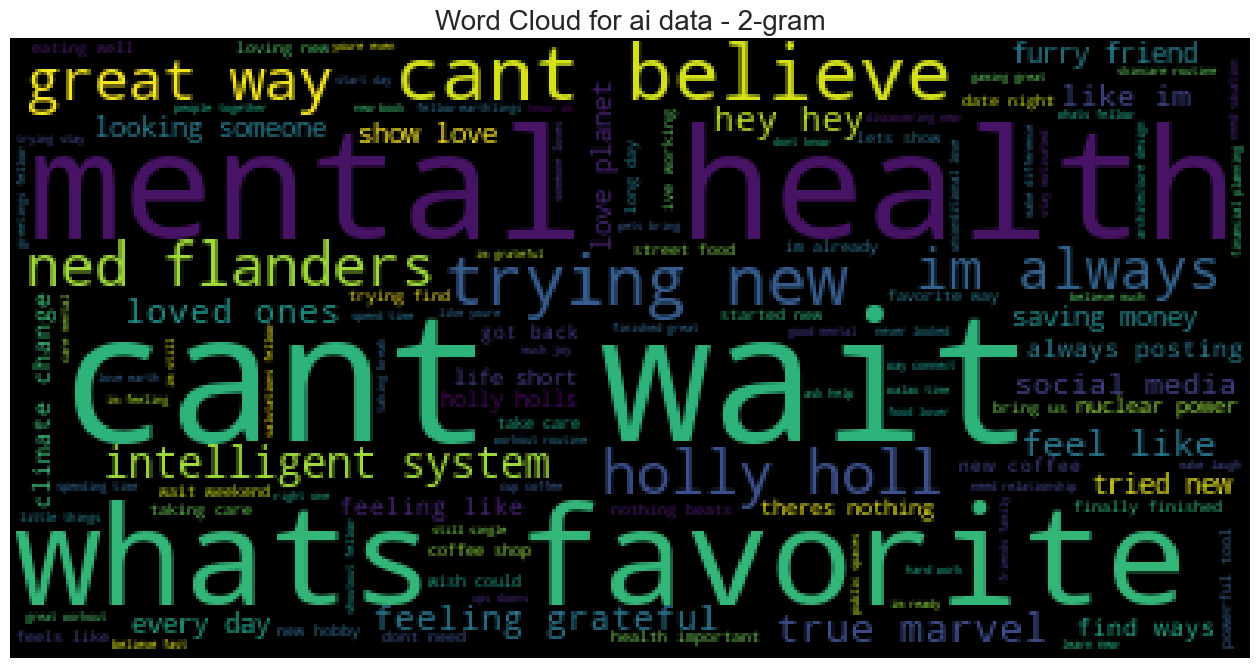

ai data - 3-gram


,Word,Frequency
0,feel like im,7
1,cant wait weekend,6
2,whats favorite way,5
3,new coffee shop,5
4,finished great workout,4
5,great way connect,4
6,holl true marvel,4
7,holly holl true,4
8,mental health important,4
9,good mental health,4


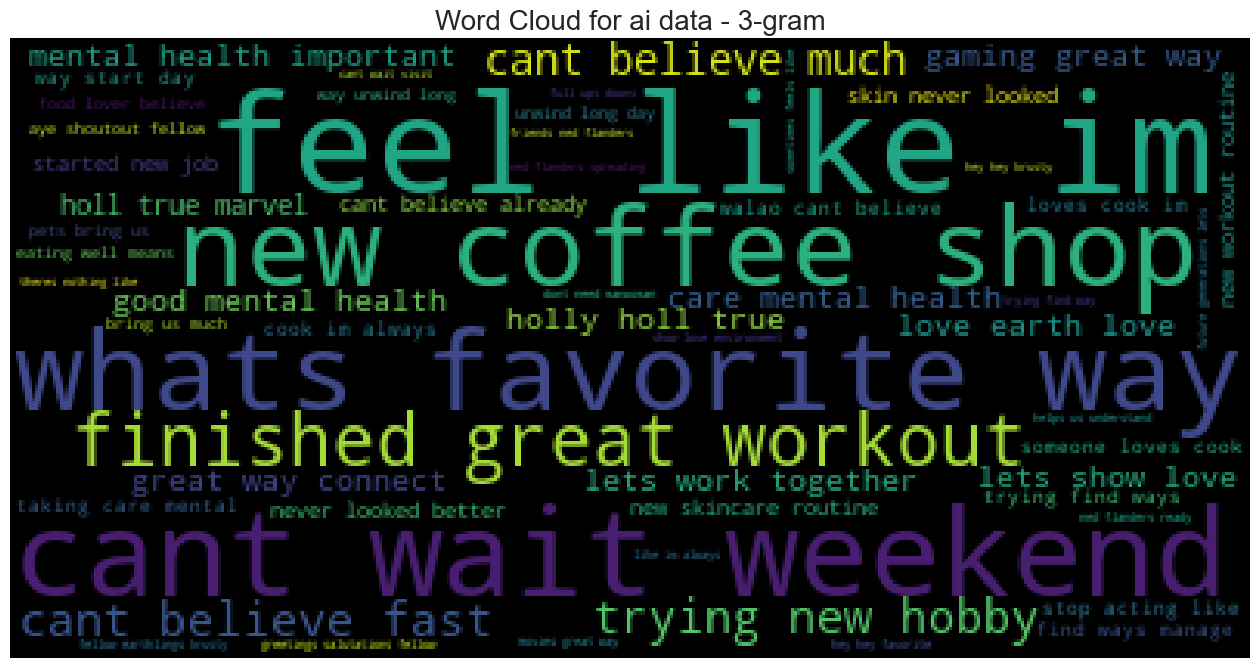

In [6]:
generate_n_gram_analysis(df)

## Cluster Analysis

- Document level analysis
- Word level analysis

#### Document Level Analysis

In [4]:
df

,body,hate,privacy,sexual,impersonation,illegal,advertisement,ai
0,kalleron design refuse collection recycling sites hear huge demand nowadays,0,0,0,0,0,0,0
1,hotmeringue2880 hi economics graduate years experience risk analyst looking make career shift people community development management suggest good mentors connect get clarity navigate shift,0,0,0,0,0,0,0
2,milenakowalska hey year finish bachelor degree informatics still sure next thinking master bioinformatics cannot find affordable option looking distance learning opportunities experience shown much easier combine full time job currently working software engineer interested natural sciences like biology physics mathematics especially theoretical maths economics banking etc also would like choose something specific informatics master like become expert area anyone ideas,0,0,0,0,0,0,0
3,rstonerphd studying makes employees want leave jobs impact employees ability leave new job study look employees want stay well survey less min complete individuals remain anonymous httpswwwsurveymonkeycomr5ppcvt5httpswwwsurveymonkeycomr5ppcvt5,0,0,0,0,0,1,0
4,temporarysection50 hi accepted job offer earlier month supervisor administrative staff ie receptionist assistants mail room clerks etc lead prior job aka right hand lady manager supervise staff members manager sick vacation rare supervisors keep morale positivewelcoming environment keep staff motivated supervisors amazing ones supervisor done make happy work environment anything helps thank,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
41198,yous muthafin lie 8220lifeasking 20pearls coreyemanuel right tl trash 8230 mine bible scriptures hymns8221,1,0,0,0,0,0,0
41199,youve gone broke wrong heart baby drove redneck crazy,0,0,0,0,0,0,0
41200,young buck wanna eat dat nigguh like aint fuckin dis,1,0,0,0,0,0,0
41201,youu got wild bitches tellin lies,1,0,0,0,0,0,0


In [5]:
def vectorise_text(text):
    vectorizer = TfidfVectorizer(stop_words=list(STOP_WORDS))
    X = vectorizer.fit_transform(text)
    return X

def elbow_method_clustering(X):
    Sum_of_squared_distances = []
    K = range(2,10)
    for k in K:
       km = KMeans(n_clusters=k, max_iter=200, n_init=10)
       km = km.fit(X)
       Sum_of_squared_distances.append(km.inertia_)
    plt.figure(figsize=(10, 8))
    sns.lineplot(x=K, y=Sum_of_squared_distances, marker=True)
    # plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()        

def cluster_text(text, X, n_clusters=5):
    model = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=200, n_init=10)
    model.fit(X)

    labels=model.labels_
    clusters=pd.DataFrame(list(zip(text,labels)),columns=['body','cluster'])
    #print(clusters.sort_values(by=['cluster']))

    return clusters


In [6]:
X = vectorise_text(df["body"])

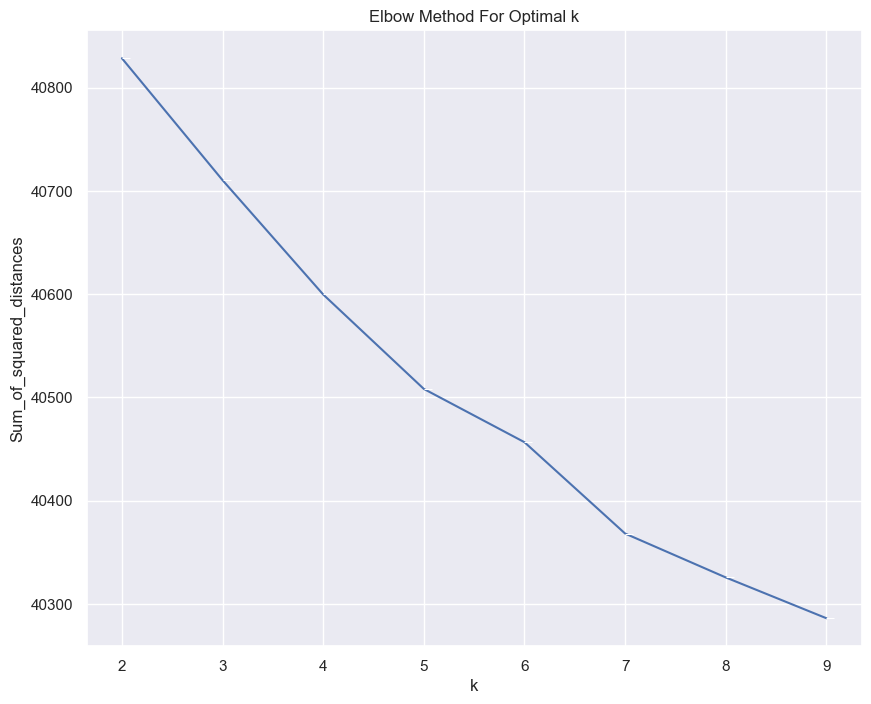

In [7]:
elbow_method_clustering(X)

In [8]:
n_clusters = 4
cluster_df = cluster_text(df['body'], X, n_clusters=4)

In [9]:
for cluster in range(n_clusters):
    print(f"Cluster {cluster}")
    display(cluster_df[cluster_df['cluster'] == cluster].head(15))
    print("=================================================================================================")

Cluster 0


,body,cluster
0,kalleron design refuse collection recycling sites hear huge demand nowadays,0
1,hotmeringue2880 hi economics graduate years experience risk analyst looking make career shift people community development management suggest good mentors connect get clarity navigate shift,0
2,milenakowalska hey year finish bachelor degree informatics still sure next thinking master bioinformatics cannot find affordable option looking distance learning opportunities experience shown much easier combine full time job currently working software engineer interested natural sciences like biology physics mathematics especially theoretical maths economics banking etc also would like choose something specific informatics master like become expert area anyone ideas,0
3,rstonerphd studying makes employees want leave jobs impact employees ability leave new job study look employees want stay well survey less min complete individuals remain anonymous httpswwwsurveymonkeycomr5ppcvt5httpswwwsurveymonkeycomr5ppcvt5,0
4,temporarysection50 hi accepted job offer earlier month supervisor administrative staff ie receptionist assistants mail room clerks etc lead prior job aka right hand lady manager supervise staff members manager sick vacation rare supervisors keep morale positivewelcoming environment keep staff motivated supervisors amazing ones supervisor done make happy work environment anything helps thank,0
5,glitterenthusiast congratulations new role supervisory title resume officially puts one rank last position smile literally leadership capacity couple things come mind regarding new role establish rapport new employees open communicating intention open communication opendoor policy etc also try genuinely get know new team mates employees spending time understanding context work well personality types try learn learning styles honest open conversations encourage employees open needs employees best understand role play helping reach goals intentionally insert push team forward hope helps,0
6,account1998 career opportunities position starting analyst postgrad good first job put foot door commodities straight college considering reputation two institutions financial institutions better would working closely wide range dpts fid risk finance compliance,0
7,quitaquites well everyone role past years stalked linkedin profiles know reality ideal possibilities,0
8,innietobby interview job really want next week going four hours long different people nervous even sleep anxious outcome want job badly advice calm nerves connect interviewer course practicing getting ready,0
9,monkeyparadiso find ways simulate experience know career coach help run qa give feedback like try get two practice sessions dont overdo sum things made point life week interview day interview relaxing self care day get exercise something enjoy happiness breads success way around gl,0


Cluster 1


,body,cluster
7744,m0derat0r41 pedo bitch nine still prison,1
10078,yyzsteven sounds like quintessential toxic corporate boss bitch adios,1
13485,al3x5 ass kicking outfit bitch,1
14249,cabinguy11 freely admit dont understand ins outs lawsuit dont get sony much bitch much money anybody making 10 year old game,1
16422,rt urkindofbrand dawg rt 80sbaby4life ever fuck bitch start cry confused shit,1
16424,rt shenikaroberts shit hear might true might faker bitch told ya 57361,1
16426,brighterdays sit hate another bitch got much shit going,1
16428,amp might get ya bitch back amp thats,1
16429,rhythmixx hobbies include fighting mariam bitch,1
16430,keeks bitch curves everyone lol walked conversation like smh,1


Cluster 2


,body,cluster
1235,dyringatory dont pussy,2
7670,lordclooch thats happens bitches throw gang signs,2
8347,riskyshot attacked sauna cuz hes unlikely gun really pussy shit haha,2
8414,cloudyromero goth boi clique make hoe shake,2
16421,rt mleew17 boy dats coldtyga dwn bad cuffin dat hoe 1st place,2
16427,8220selfiequeenbri cause im tired big bitches coming us skinny girls8221,2
16433,bad bitches thing like,2
16438,bitches get cut everyday,2
16445,pussy lips like heaven doors 128524,2
16446,hoe hitting,2


Cluster 3


,body,cluster
16425,tmadisonx shit blows meclaim faithful somebody still fucking hoes 128514128514128514,3
16432,hoes smoke losers yea go ig,3
16442,cant see hoes wont change,3
16458,lames crying hoes thats tears clown,3
16459,like snoop said 94 dont love hoes,3
16461,hated hoes favorite 2mw sevenone httptcobmdsvmc3rc,3
16463,pimps pimps hoes future voice,3
16469,hoes like niggas spend money talk bout,3
16471,yall niggas cuffing hoes cause yall aint never bitches,3
16474,128514128514128514128514128514128514128514128514128514128514128514vandalsavage teanna trump probably cleaner twitter hoes,3


#### Word Level Analysis

In [46]:
# Constructing dictionary of unique words from raw text

def construct_dictionary(text, combined_dict):

    # Constructing dictionary
    for word in text.split():
        if word not in combined_dict:
            combined_dict[word] = len(combined_dict)

    return combined_dict

def generate_dict(df):
    output_dict = {}
    df["body"].apply(lambda x: construct_dictionary(x, output_dict))
    return output_dict

# Download and pickle pre-trained model

def download_model(model_name):
    time_start = time.time()
    model = api.load(model_name)
    print(f"INFO: model loaded in {time.time() - time_start} seconds")
    with open(f"cache_files/{model_name}.pickle", "wb") as f:
        pickle.dump(model, f)

def load_model(model_name):
    with open(f"cache_files/{model_name}.pickle", "rb") as f:
        model = pickle.load(f)
    return model

# Get embeddings from pre-trained model

def get_embeddings(model, word):
    if model.__contains__(word):
        return np.array(model[word])
    else:
        return None

# Transforming text to vector using a pre-trained model glove-wiki-gigaword-50

def transform_text_to_vector(dictionary):
    
    # Transforming text to vector
    try:
        model = load_model("glove-wiki-gigaword-50")
        print("INFO: glove-wiki-gigaword-50 loaded.")
    except:
        print("INFO: Downloading glove-wiki-gigaword-50 loaded.")
        download_model("glove-wiki-gigaword-50")
        model = load_model("glove-wiki-gigaword-50")
        print("INFO: glove-wiki-gigaword-50 loaded.")


    vectorised_text = {}
    print("INFO: Transforming text to vector.")
    for word in dictionary.keys():
        if get_embeddings(model, word) is not None:
            vectorised_text[word] = get_embeddings(model, word)

    return vectorised_text

# Clustering vectors using k-means

def cluster_vectors(vectorised_text, n_clusters=3, n_samples=100):

    # Clustering vectors
    print(f"INFO: Clustering vectors using k-means for n_clusters = {n_clusters}.")    
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42).fit(list(vectorised_text.values()))

    # Calculating within cluster sum of squares
    print("INFO: Calculating within cluster sum of squares.")
    wcss = kmeans.inertia_

    # Transforming vectors to 2D space for visualisation
    print("INFO: Transforming vectors to 2D space for visualisation.")
    tsne = TSNE(n_components=2, random_state=42, perplexity=50)
    vectors_2d = tsne.fit_transform(np.array(list(vectorised_text.values())))

    # Creating dataframe for visualisation
    print("INFO: Creating dataframe for visualisation.")
    vectors_2d = pd.DataFrame(vectors_2d, columns=['x', 'y'])
    vectors_2d['cluster'] = kmeans.labels_
    vectors_2d['word'] = list(vectorised_text.keys())

    # Sampling 100 points for visualisation
    print("INFO: Sampling 100 points for visualisation.")
    vectors_2d = vectors_2d.sample(min(n_samples, vectors_2d.shape[0]))
    vectors_2d = vectors_2d.reset_index(drop=True)

    # Visualising clusters
    print("INFO: Visualising clusters.")
    fig, ax = plt.subplots(figsize=(20, 20))
    sns.scatterplot(x='x', y='y', hue='cluster', data=vectors_2d, ax=ax)

    # annotating points
    for i, point in vectors_2d.iterrows():
        ax.text(point.x, point.y, point.word, fontsize=12)
        
    plt.title(f"Clusters of words for n_clusters = {n_clusters}", fontsize=20)
    plt.show()

    # Assigning cluster to each word
    print("INFO: Assigning cluster to each word.")
    for i, word in enumerate(vectorised_text.keys()):
        vectorised_text[word] = kmeans.labels_[i]
        
    return vectorised_text, vectors_2d, wcss

# Elbow method for determining optimal number of clusters

def elbow_method(df, max_clusters=10, display=True):
    dictionary = generate_dict(df)

    wcss = []
    for i in range(2, max_clusters+1):
        vectorised_text = transform_text_to_vector(dictionary)
        _, _, wcss_ = cluster_vectors(vectorised_text, n_clusters=i)
        wcss.append(wcss_)
    # plotting the results onto a line graph using seaborn
    if display:
        plt.figure(figsize=(10, 10))
        sns.lineplot(x=range(1, max_clusters), y=wcss)
        plt.title('The elbow method')
        plt.xlabel('Number of clusters')
        plt.ylabel('WCSS') # within cluster sum of squares
        plt.show()


In [ ]:
elbow_method(df, max_clusters=10, display=False)

INFO: glove-wiki-gigaword-50 loaded.
INFO: Transforming text to vector.
INFO: Clustering vectors using k-means for n_clusters = 4.
INFO: Calculating within cluster sum of squares.
INFO: Transforming vectors to 2D space for visualisation.
INFO: Creating dataframe for visualisation.
INFO: Sampling 100 points for visualisation.
INFO: Visualising clusters.


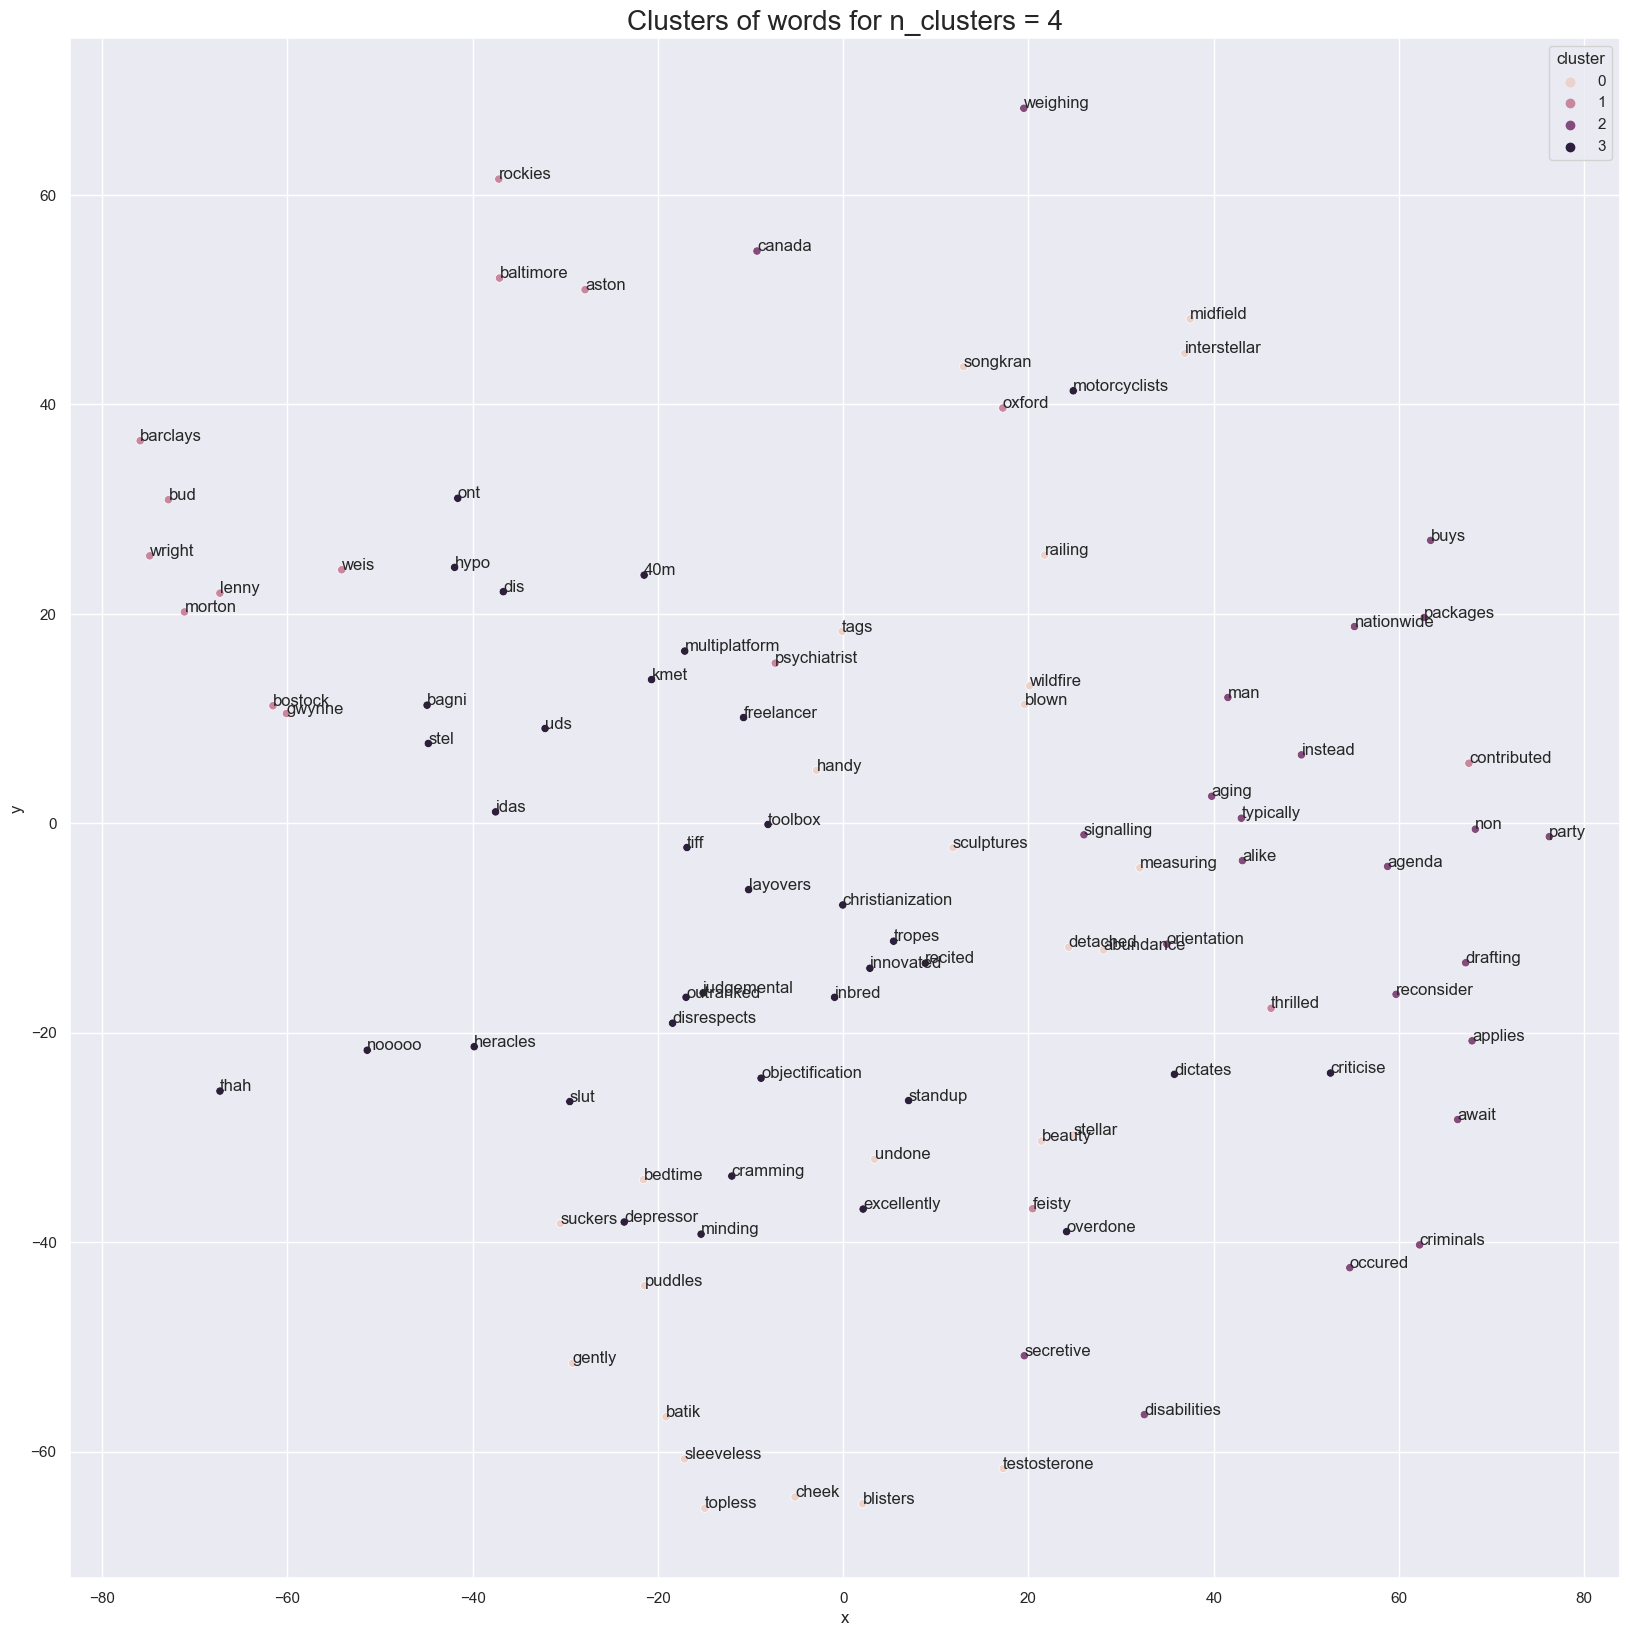

INFO: Assigning cluster to each word.


In [48]:
n_clusters = 4
n_samples = 100
dictionary = generate_dict(df)
vectorised_text = transform_text_to_vector(dictionary)

vectorised_text_output, vectors_2d, wcss = cluster_vectors(vectorised_text, n_clusters=n_clusters, n_samples=n_samples)

In [49]:
word_clusters = pd.DataFrame(vectorised_text_output, index=["Cluster"]).T.reset_index().rename(columns={"index": "Word"})

In [51]:
for cluster in range(n_clusters):
    # print(f"Cluster {cluster}")
    display(word_clusters[word_clusters["Cluster"] == cluster].head(20))
    # print("=================================================================================================")


,Word,Cluster
3,recycling,0
30,navigate,0
53,combine,0
114,room,0
133,amazing,0
152,smile,0
153,literally,0
179,styles,0
191,insert,0
198,foot,0


,Word,Cluster
9,hi,1
15,analyst,1
31,hey,1
60,engineer,1
98,min,1
107,supervisor,1
111,receptionist,1
112,assistants,1
118,aka,1
121,lady,1


,Word,Cluster
0,design,2
1,refuse,2
2,collection,2
4,sites,2
5,hear,2
6,huge,2
7,demand,2
8,nowadays,2
10,economics,2
11,graduate,2


,Word,Cluster
26,mentors,3
36,informatics,3
42,bioinformatics,3
70,maths,3
72,etc,3
110,ie,3
162,rapport,3
212,fid,3
218,linkedin,3
250,qa,3


## Polarity Analysis

In [13]:
# Polarity analysis for text

def polarity_analysis(text):
    polarity = TextBlob(text).sentiment.polarity
    return polarity

df["polarity"] = df["body"].apply(lambda x: polarity_analysis(x))

In [14]:
# Previewing text with highest polarity

df.sort_values(by="polarity", ascending=False).head(10)[["body", "polarity"]]

,body,polarity
30061,one markschlabach best looks rt mcmurphyespn charlie weis couple months ago hanging wnelly httptcoywvvg51z6w,1.0
1923,abbime looks delicious,1.0
12320,sequentialgearbox perfect form speak,1.0
1549,furrydrift look real good wish could try one,1.0
27566,id best owning bird could teach funniest things say,1.0
15445,always posting travels impressive wasteofmoney travelbrag,1.0
4207,mdins1980 cant remember article days ago perfectly summarized woke means rightwing dipt america acknowledging racism thing ever happened andor lgbtq people exist,1.0
10951,acceptabledelay559 midnight mass excellent,1.0
15436,youre always posting perfect life stop bragging jealous fakelife,1.0
16000,investing best investment make investinyourself financialfreedom,1.0


In [15]:
# Previewing text with lowest polarity

df.sort_values(by="polarity", ascending=True).head(10)[["body", "polarity"]]

,body,polarity
6276,papishot worst train wreck ohio,-1.0
36851,rt z0mbiedance gabbys bitch amp turned xbox nasty foot,-1.0
6992,lostinthetrash4ever peace us cruel world god wills,-1.0
36628,rt tonymoore found cheese cracker sandwiches cabinet year expired ate anyway die tonight worst l8230,-1.0
35185,rt churchofbasebal people say baseball boring redskins,-1.0
29443,doctor tonight miserable cunt even nurse pissed shes since 7pm hasnt come see,-1.0
19007,bidenshairplugs looks like fag time line boring zzzzzz,-1.0
37738,terrifying leprechaun httptco447wgksvvg,-1.0
33808,rt spencelynn idk people job stay home day watching tv boring days idk ho8230,-1.0
32854,rt meyakardashian bitch fucking insane 8220twiterdezenuts sentence describes words8221,-1.0


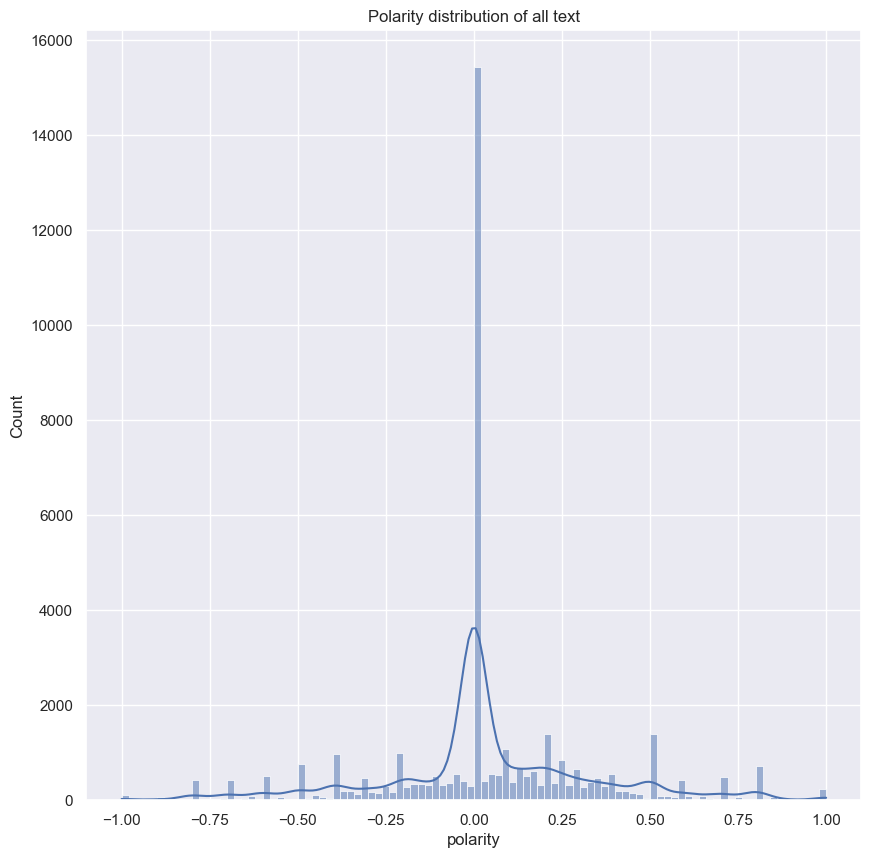

In [20]:
# Visualising polarity distribution

plt.figure(figsize=(10, 10))
sns.histplot(df["polarity"], bins=100, kde=True)
plt.title("Polarity distribution of all text")
plt.show()


#### Polarity Analysis by Target Type

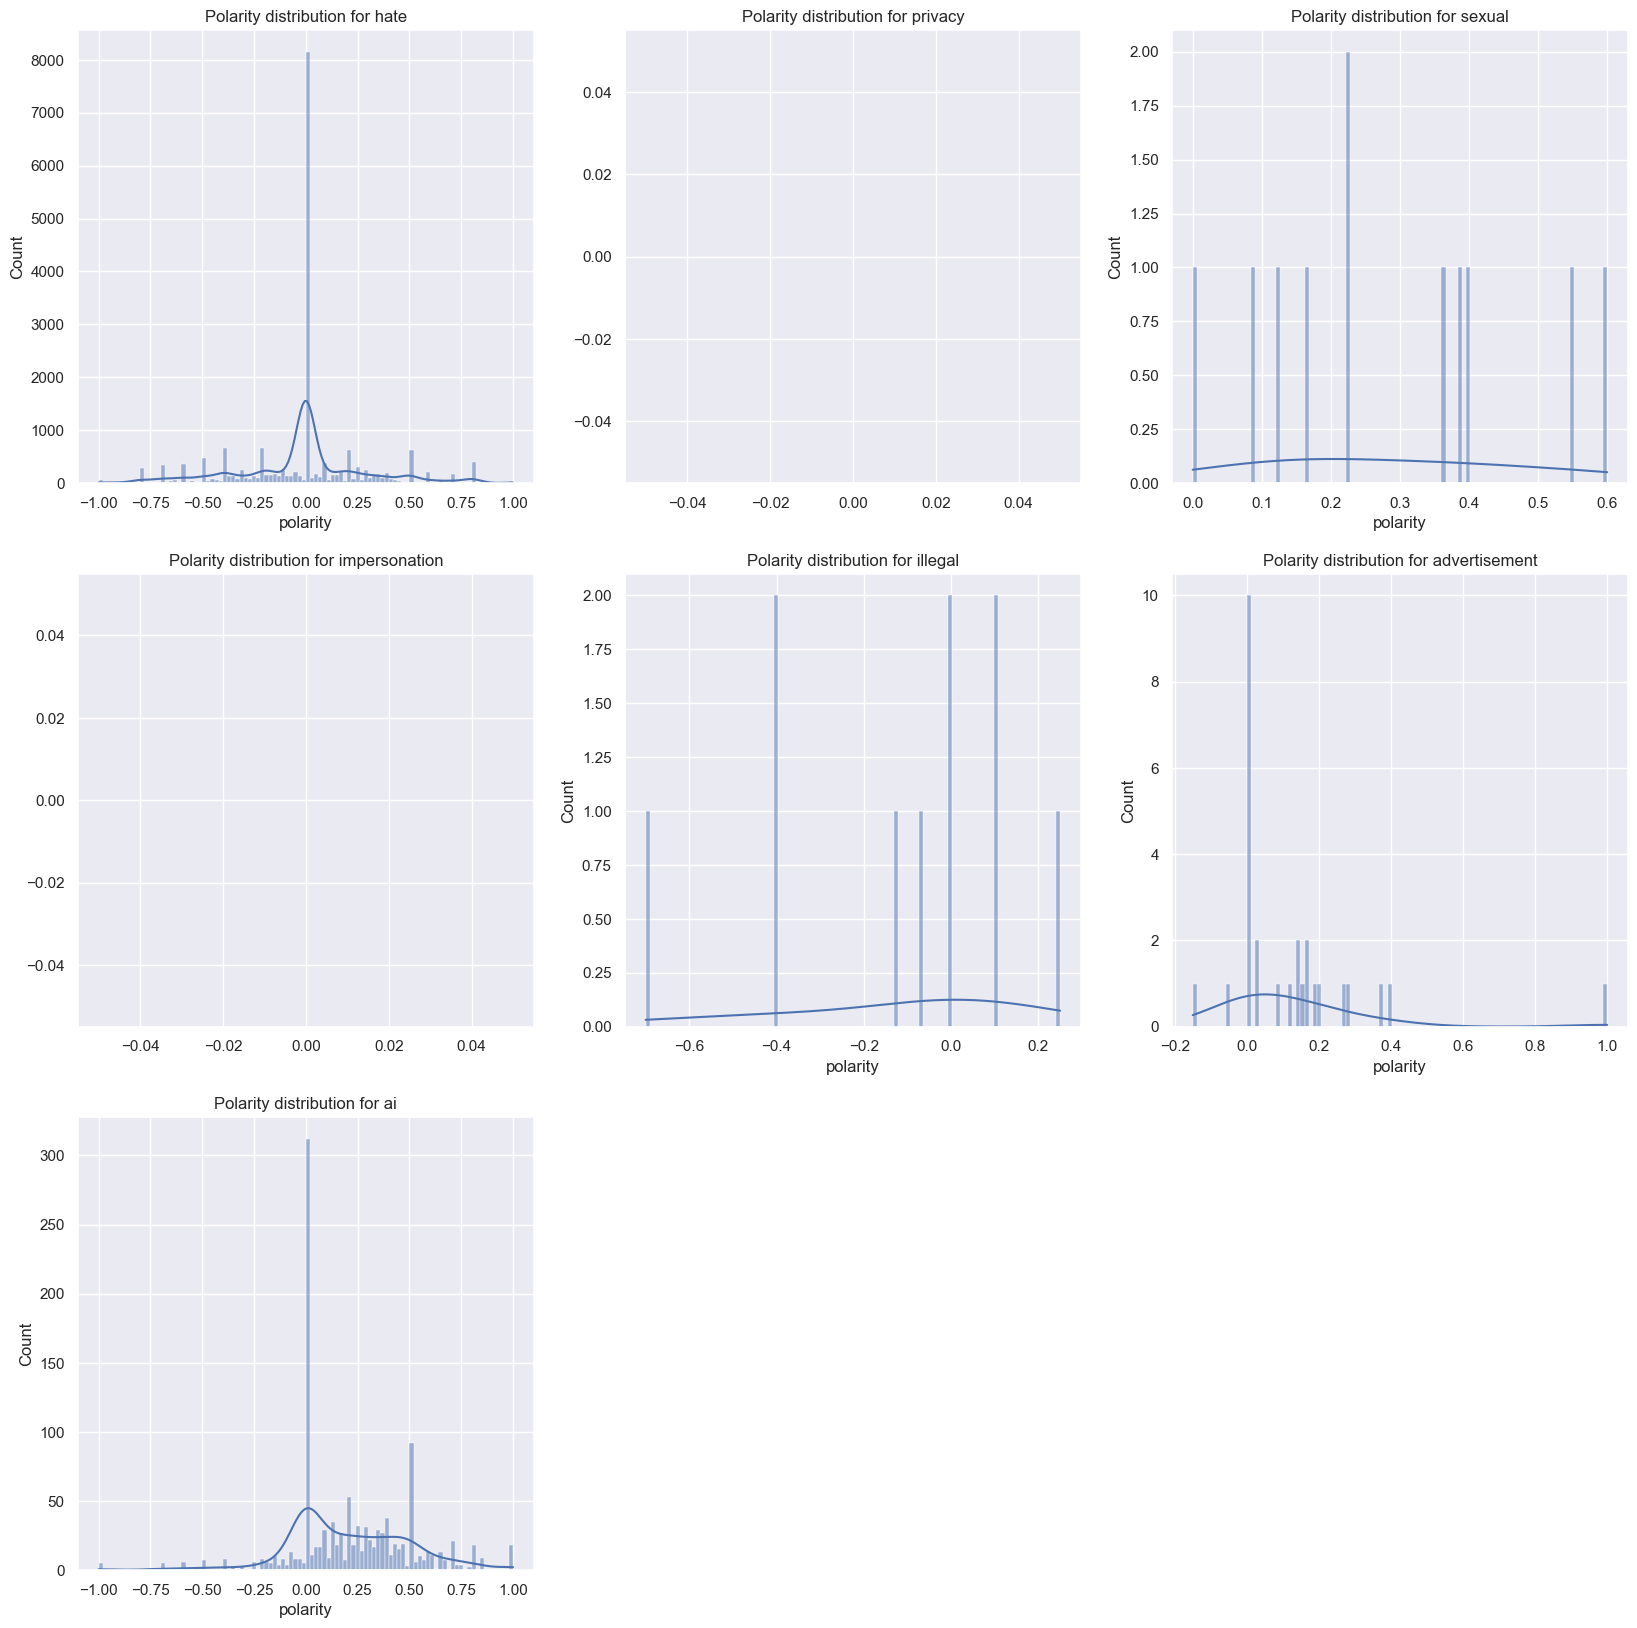

In [39]:
# Plotting polarity distribution for each target in TARGET_VARS in subplots

fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for i, target in enumerate(TARGET_VARS):
    sns.histplot(df[df[target] == 1]["polarity"], bins=100, kde=True, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f"Polarity distribution for {target}")
axes[2, 1].set_visible(False)
axes[2, 2].set_visible(False)


In [9]:
# Merge cluster_df and df on index

df_merged = df.merge(cluster_df, on="body")

In [11]:
df_merged.to_csv("data/df_merged.csv", index=False)

In [16]:
df_merged = pd.read_csv("data/df_merged.csv")

In [17]:
df_merged

,body,hate,privacy,sexual,impersonation,illegal,advertisement,ai,cluster
0,kalleron design refuse collection recycling sites hear huge demand nowadays,0,0,0,0,0,0,0,1
1,hotmeringue2880 hi economics graduate years experience risk analyst looking make career shift people community development management suggest good mentors connect get clarity navigate shift,0,0,0,0,0,0,0,1
2,milenakowalska hey year finish bachelor degree informatics still sure next thinking master bioinformatics cannot find affordable option looking distance learning opportunities experience shown much easier combine full time job currently working software engineer interested natural sciences like biology physics mathematics especially theoretical maths economics banking etc also would like choose something specific informatics master like become expert area anyone ideas,0,0,0,0,0,0,0,1
3,rstonerphd studying makes employees want leave jobs impact employees ability leave new job study look employees want stay well survey less min complete individuals remain anonymous httpswwwsurveymonkeycomr5ppcvt5httpswwwsurveymonkeycomr5ppcvt5,0,0,0,0,0,1,0,1
4,rstonerphd studying makes employees want leave jobs impact employees ability leave new job study look employees want stay well survey less min complete individuals remain anonymous httpswwwsurveymonkeycomr5ppcvt5httpswwwsurveymonkeycomr5ppcvt5,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...
43772,yous muthafin lie 8220lifeasking 20pearls coreyemanuel right tl trash 8230 mine bible scriptures hymns8221,1,0,0,0,0,0,0,1
43773,youve gone broke wrong heart baby drove redneck crazy,0,0,0,0,0,0,0,1
43774,young buck wanna eat dat nigguh like aint fuckin dis,1,0,0,0,0,0,0,1
43775,youu got wild bitches tellin lies,1,0,0,0,0,0,0,2


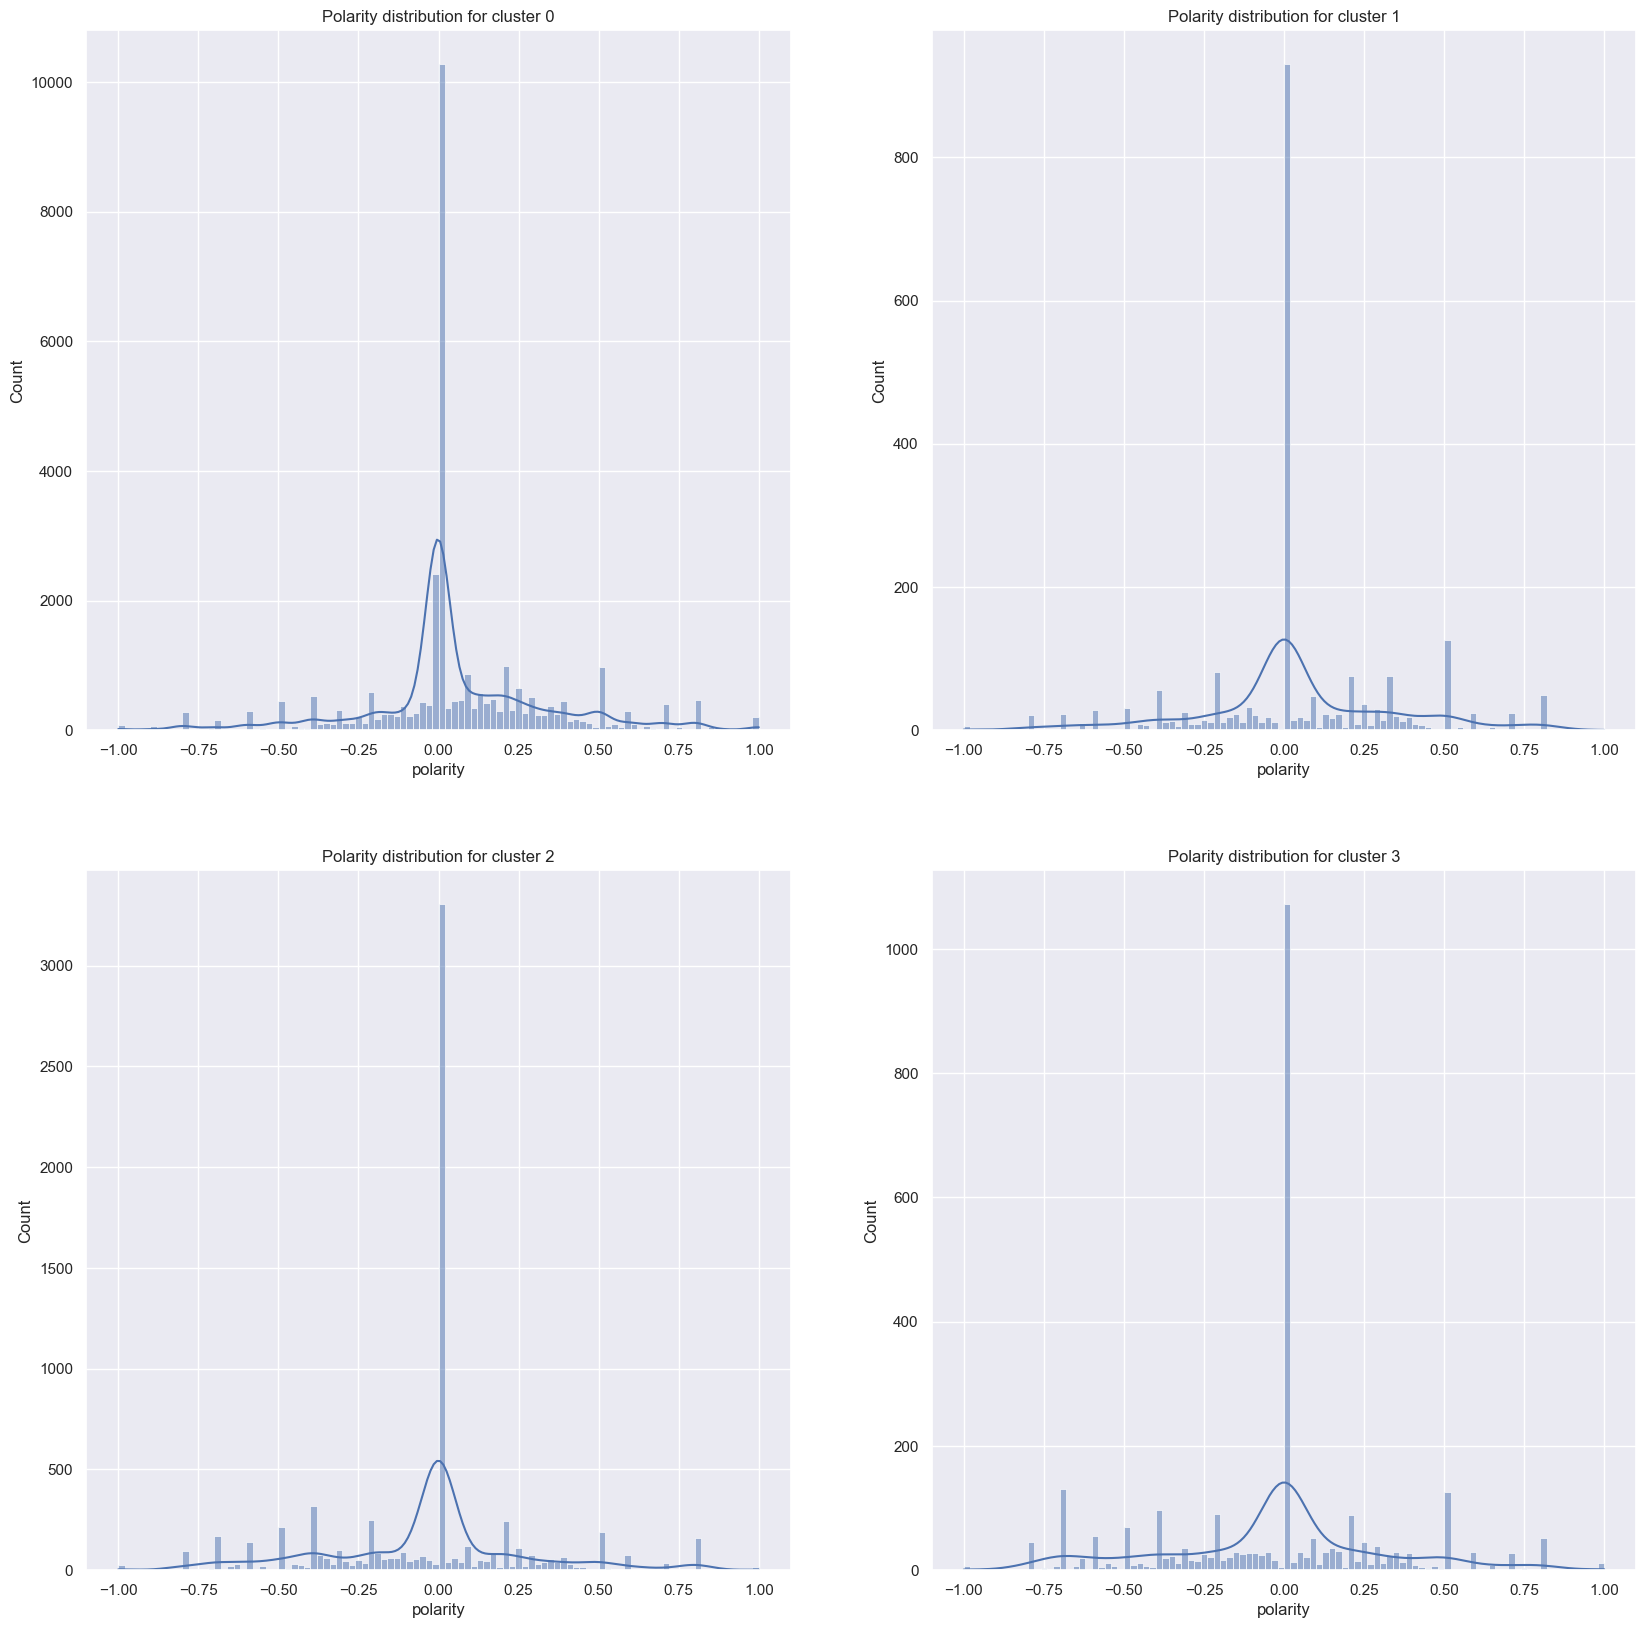

In [77]:
# Plotting polarity distribution for each cluster in subplots

fig, axes = plt.subplots(2, 2, figsize=(20, 20))
for i, cluster in enumerate(range(n_clusters)):
    sns.histplot(df_merged[df_merged["cluster"] == cluster]["polarity"], bins=100, kde=True, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f"Polarity distribution for cluster {cluster}")


### Perplexity Analysis

In [11]:
def train_MLE_model(df_train, n=1):
    train_sentences = list(df_train['body'].values)
    tokenized_text = [list(map(str.lower, nltk.tokenize.word_tokenize(sent))) 
                    for sent in train_sentences]
    train_data, padded_vocab = padded_everygram_pipeline(n, tokenized_text)
    model = MLE(n)
    model.fit(train_data, padded_vocab)
    return model

def perplexity(model, df_test, n=1):
    test_sentences = list(df_test['body'].values)
    tokenized_text = [list(map(str.lower, nltk.tokenize.word_tokenize(sent))) 
                    for sent in test_sentences]
    test_data, _ = padded_everygram_pipeline(n, tokenized_text)
    results = {"body":[], "perplexity":[]}
    for i, test in enumerate(test_data):
        results["body"].append(test_sentences[i])
        results["perplexity"].append(model.perplexity(test))

    return pd.DataFrame(results)

In [34]:
# Perplexity for unigram model

df_train, df_test = train_test_split(df_merged, test_size=0.7, random_state=RANDOM_STATE, stratify=df_merged["ai"])
mle_unigram_model = train_MLE_model(df_train, n=1)
perplexity_unigram_results_df = perplexity(mle_unigram_model, df_test, n=1)

In [44]:
df_test = df_test.sort_values(by="body").reset_index(drop=True)
perplexity_unigram_results_df = perplexity_unigram_results_df.sort_values(by="body").reset_index(drop=True)

In [47]:
# merge with df_test on index
perplexity_unigram_results_df_merged = df_test.merge(perplexity_unigram_results_df, left_index=True, right_index=True).drop(columns=["body_y"]).rename(columns={"body_x": "body"})

In [48]:
perplexity_unigram_results_df_merged

,body,hate,privacy,sexual,impersonation,illegal,advertisement,ai,cluster,perplexity
0,01101101010100111100 never use prime due fact stuff included subscription mixed store pay movies shows big also fuck amazon,0,0,0,0,0,0,0,1,inf
1,013ander get many conservatives resent left looking insist digging deep hole live,0,0,0,0,0,0,0,1,inf
2,03madara05 imagine sexually assaulting 13 year old distributing child porn snitching gang members still walking around like fact happened might actually make guy luckiest piece shit earth,0,0,0,0,1,0,0,1,inf
3,049at never tell truth ask stuff want someone stay 510 years underpay game play assholes,0,0,0,0,0,0,0,1,inf
4,04still20smokin69 dirt alice chains,0,0,0,0,0,0,0,1,inf
...,...,...,...,...,...,...,...,...,...,...
30639,zz9za like mike pence charisma charm wet paper bag people see less like,0,0,0,0,0,0,0,1,inf
30640,zzrsteve recipe dr sheldon cooper noble prize winning physicist,0,0,0,0,0,0,0,1,inf
30641,zzrsteve shit like earlier games makes march madness possibly greatest spectacle sport least one greatest,0,0,0,0,0,0,0,1,inf
30642,zzxxccbbvn ill interesting see cancel tomorrow anything would imagine logistical planning behind coordinating arrest getting antsy though hope tomorrow day happens,0,0,0,0,0,0,0,1,inf


c:\Users\edmun\Dropbox\NUS\Work\Y4S2\IS4242\is4242-group8\venv\lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
c:\Users\edmun\Dropbox\NUS\Work\Y4S2\IS4242\is4242-group8\venv\lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


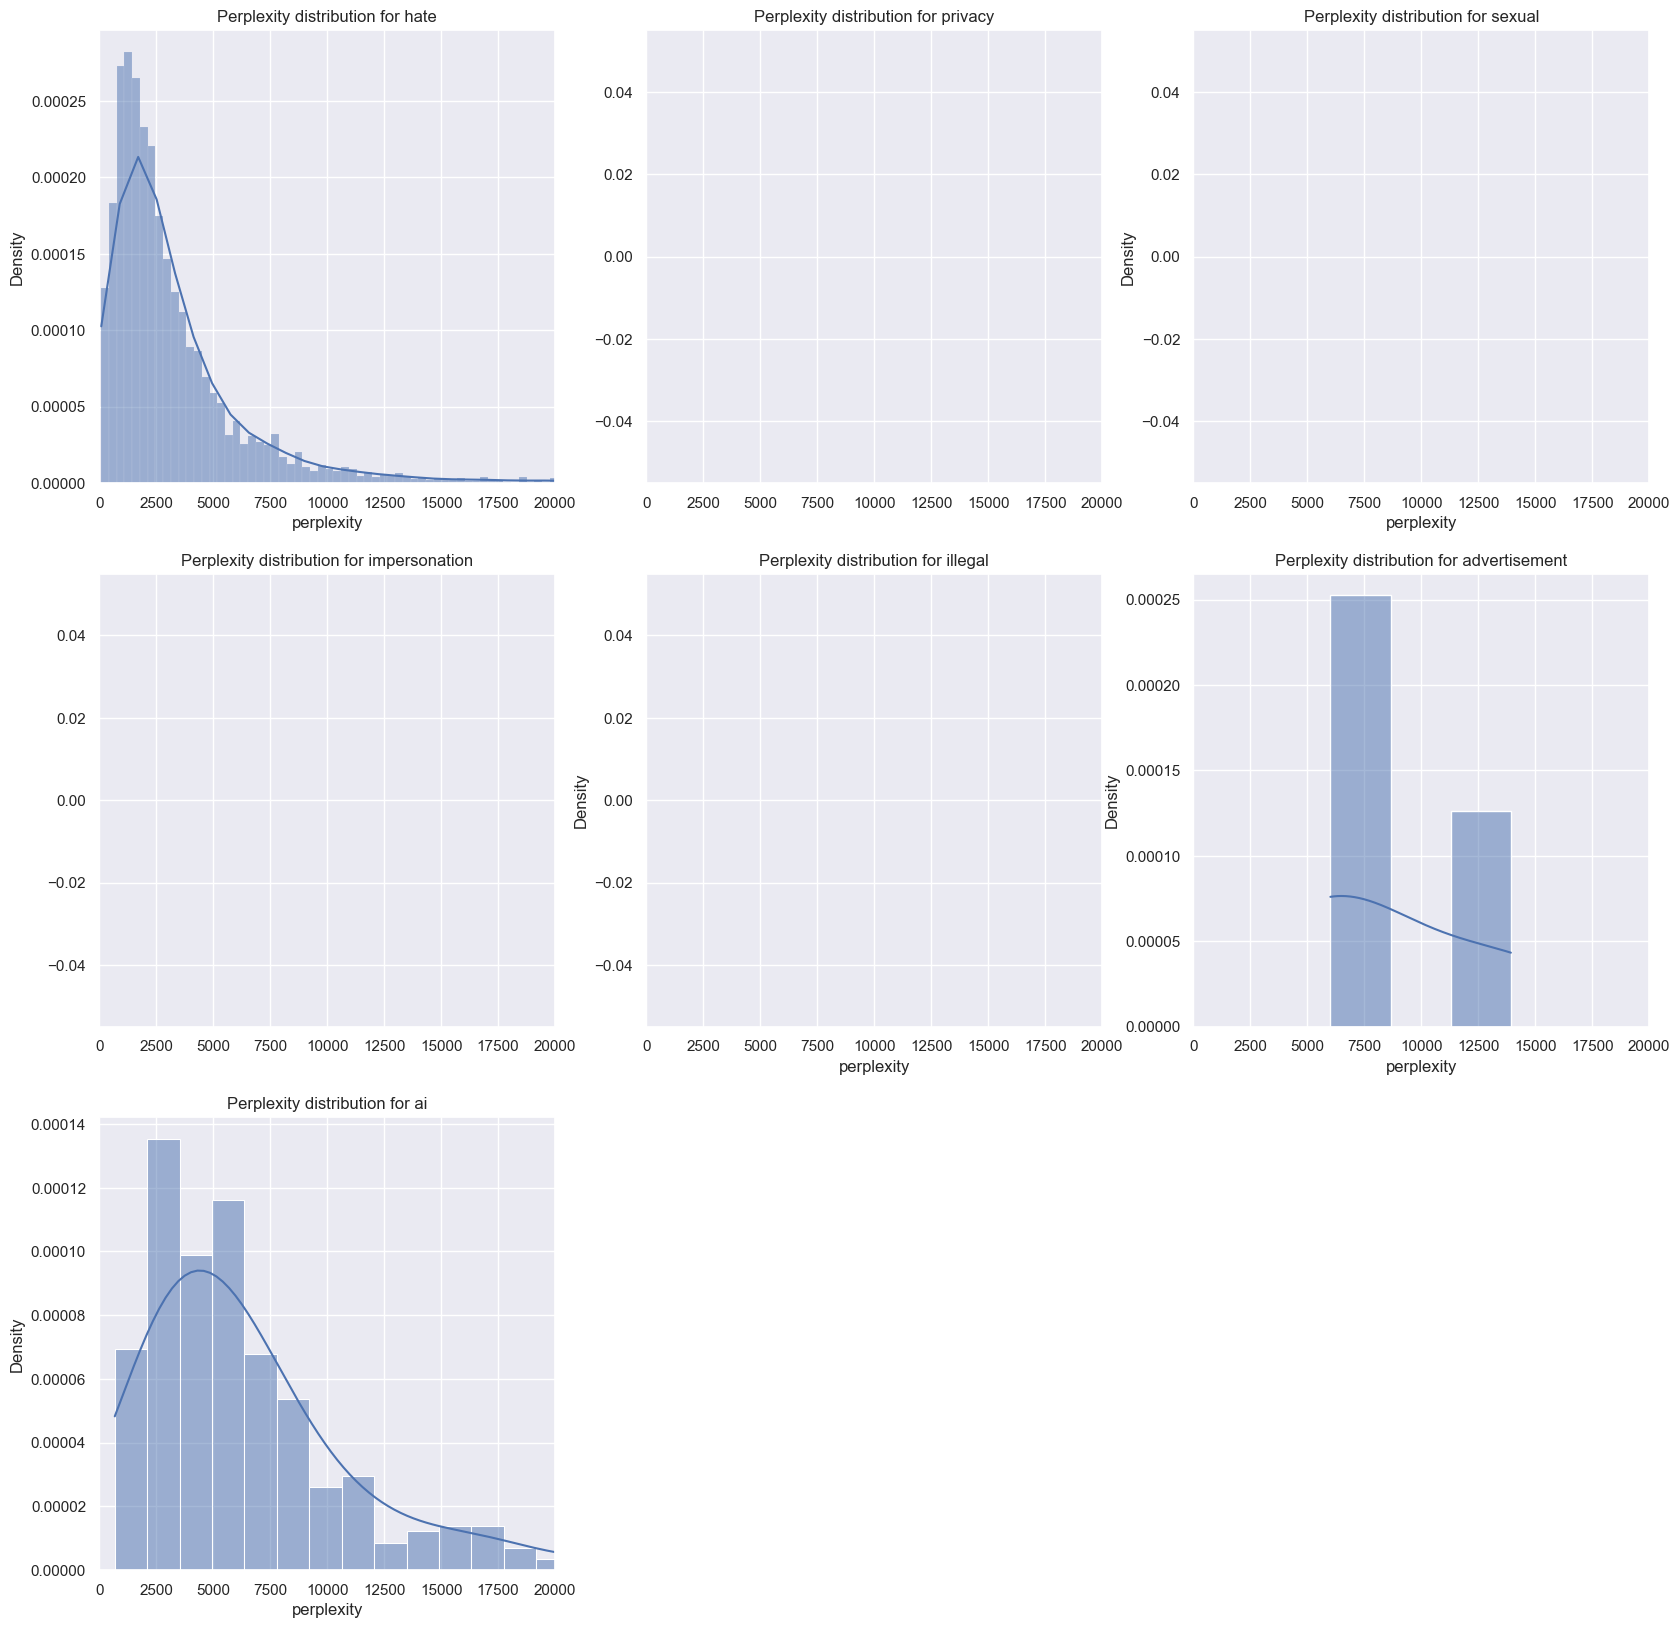

In [49]:
# plotting distribution of perplexity for unigram model for each target

fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for i, target in enumerate(TARGET_VARS):
    sns.histplot(perplexity_unigram_results_df_merged[perplexity_unigram_results_df_merged[target] == 1]["perplexity"], kde=True, ax=axes[i//3, i%3], stat="density")
    axes[i//3, i%3].set_xlim(0, 20000)
    axes[i//3, i%3].set_title(f"Perplexity distribution for {target}")
axes[2, 1].set_visible(False)
axes[2, 2].set_visible(False)



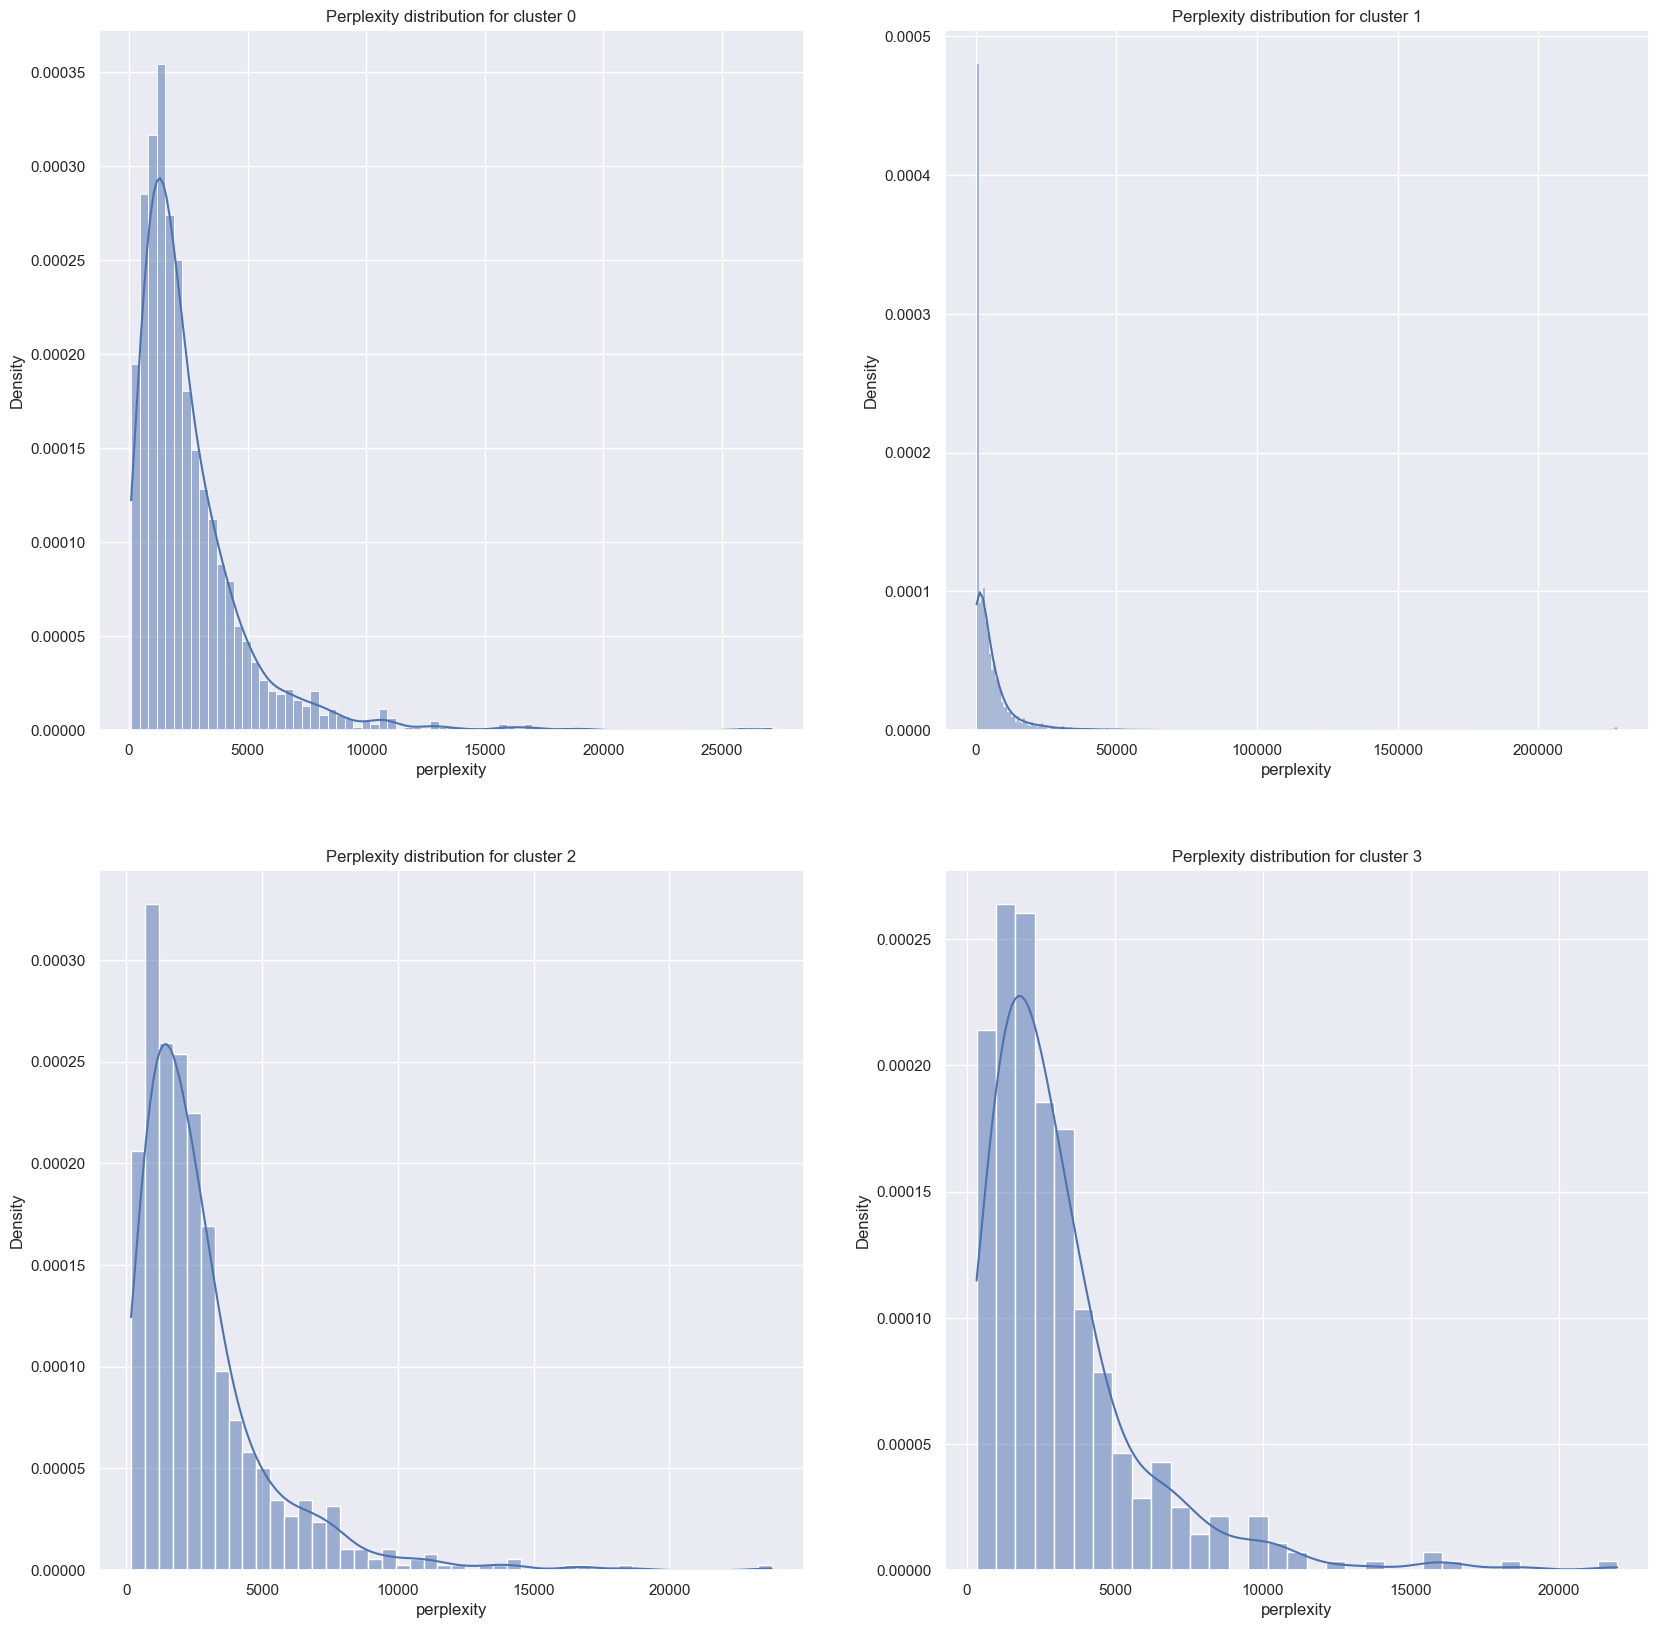

In [50]:
# plotting distribution of perplexity for unigram model for each cluster

fig, axes = plt.subplots(2, 2, figsize=(20, 20))
for i in range(n_clusters):
    sns.histplot(perplexity_unigram_results_df_merged[perplexity_unigram_results_df_merged["cluster"] == i]["perplexity"], kde=True, ax=axes[i//2, i%2], stat="density")
    axes[i//2, i%2].set_title(f"Perplexity distribution for cluster {i}")




In [51]:
perplexity_unigram_results_df_merged.to_csv("data/perplexity_unigram_results_df_merged.csv", index=False)

In [52]:
perplexity_unigram_results_df_merged = pd.read_csv("data/perplexity_unigram_results_df_merged.csv")

### Burstiness Analysis

In [72]:
df_merged

,body,hate,privacy,sexual,impersonation,illegal,advertisement,ai,cluster
0,kalleron design refuse collection recycling sites hear huge demand nowadays,0,0,0,0,0,0,0,1
1,hotmeringue2880 hi economics graduate years experience risk analyst looking make career shift people community development management suggest good mentors connect get clarity navigate shift,0,0,0,0,0,0,0,1
2,milenakowalska hey year finish bachelor degree informatics still sure next thinking master bioinformatics cannot find affordable option looking distance learning opportunities experience shown much easier combine full time job currently working software engineer interested natural sciences like biology physics mathematics especially theoretical maths economics banking etc also would like choose something specific informatics master like become expert area anyone ideas,0,0,0,0,0,0,0,1
3,rstonerphd studying makes employees want leave jobs impact employees ability leave new job study look employees want stay well survey less min complete individuals remain anonymous httpswwwsurveymonkeycomr5ppcvt5httpswwwsurveymonkeycomr5ppcvt5,0,0,0,0,0,1,0,1
4,rstonerphd studying makes employees want leave jobs impact employees ability leave new job study look employees want stay well survey less min complete individuals remain anonymous httpswwwsurveymonkeycomr5ppcvt5httpswwwsurveymonkeycomr5ppcvt5,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...
43772,yous muthafin lie 8220lifeasking 20pearls coreyemanuel right tl trash 8230 mine bible scriptures hymns8221,1,0,0,0,0,0,0,1
43773,youve gone broke wrong heart baby drove redneck crazy,0,0,0,0,0,0,0,1
43774,young buck wanna eat dat nigguh like aint fuckin dis,1,0,0,0,0,0,0,1
43775,youu got wild bitches tellin lies,1,0,0,0,0,0,0,2


In [61]:
# Burstiness analysis

def calculate_burstiness(text):
    tokens = nltk.word_tokenize(text)
    word_freq = nltk.FreqDist(tokens)
    freq_values = np.array(list(word_freq.values()))
    mean = np.mean(freq_values)
    variance = np.var(freq_values)
    burstiness = (variance - mean) / mean
    return abs(burstiness)


In [73]:
df_merged["burstiness"] = df_merged["body"].apply(lambda x: calculate_burstiness(x))

In [74]:
df_merged

,body,hate,privacy,sexual,impersonation,illegal,advertisement,ai,cluster,burstiness
0,kalleron design refuse collection recycling sites hear huge demand nowadays,0,0,0,0,0,0,0,1,1.000000
1,hotmeringue2880 hi economics graduate years experience risk analyst looking make career shift people community development management suggest good mentors connect get clarity navigate shift,0,0,0,0,0,0,0,1,0.960145
2,milenakowalska hey year finish bachelor degree informatics still sure next thinking master bioinformatics cannot find affordable option looking distance learning opportunities experience shown much easier combine full time job currently working software engineer interested natural sciences like biology physics mathematics especially theoretical maths economics banking etc also would like choose something specific informatics master like become expert area anyone ideas,0,0,0,0,0,0,0,1,0.906241
3,rstonerphd studying makes employees want leave jobs impact employees ability leave new job study look employees want stay well survey less min complete individuals remain anonymous httpswwwsurveymonkeycomr5ppcvt5httpswwwsurveymonkeycomr5ppcvt5,0,0,0,0,0,1,0,1,0.803543
4,rstonerphd studying makes employees want leave jobs impact employees ability leave new job study look employees want stay well survey less min complete individuals remain anonymous httpswwwsurveymonkeycomr5ppcvt5httpswwwsurveymonkeycomr5ppcvt5,0,0,0,0,0,1,0,1,0.803543
...,...,...,...,...,...,...,...,...,...,...
43772,yous muthafin lie 8220lifeasking 20pearls coreyemanuel right tl trash 8230 mine bible scriptures hymns8221,1,0,0,0,0,0,0,1,1.000000
43773,youve gone broke wrong heart baby drove redneck crazy,0,0,0,0,0,0,0,1,1.000000
43774,young buck wanna eat dat nigguh like aint fuckin dis,1,0,0,0,0,0,0,1,1.000000
43775,youu got wild bitches tellin lies,1,0,0,0,0,0,0,2,1.000000


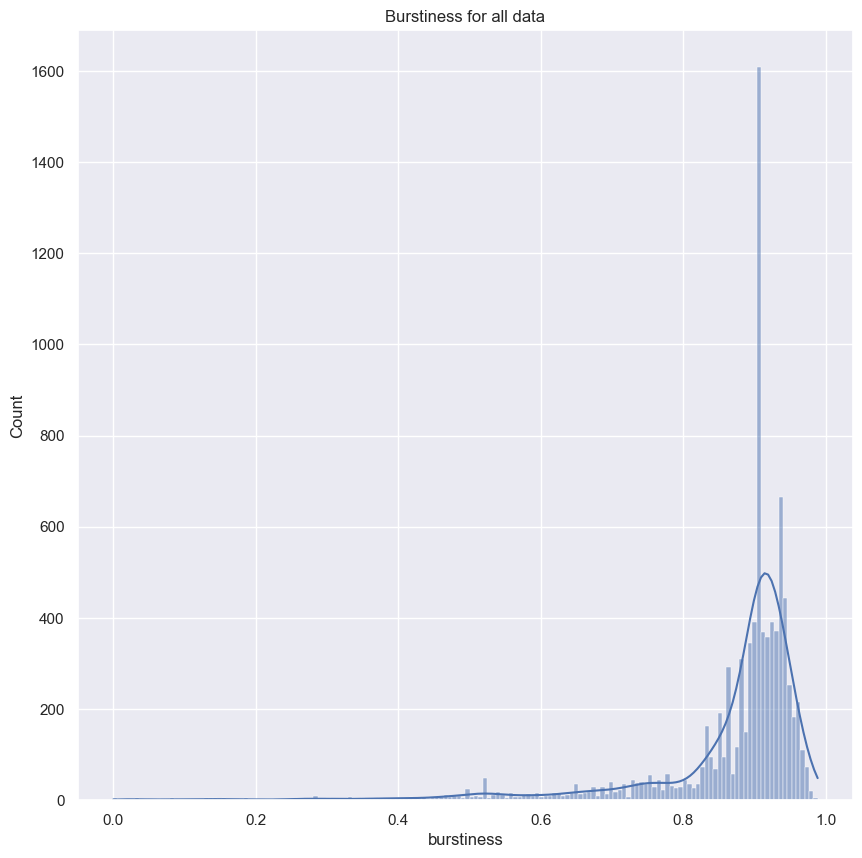

In [75]:
burstiness_filtered = perplexity_unigram_results_df_merged[perplexity_unigram_results_df_merged["burstiness"] < 1]

# plotting distribution of burstiness for all
plt.figure(figsize=(10, 10))
sns.histplot(burstiness_filtered["burstiness"], kde=True)
plt.title("Burstiness for all data")
plt.show()

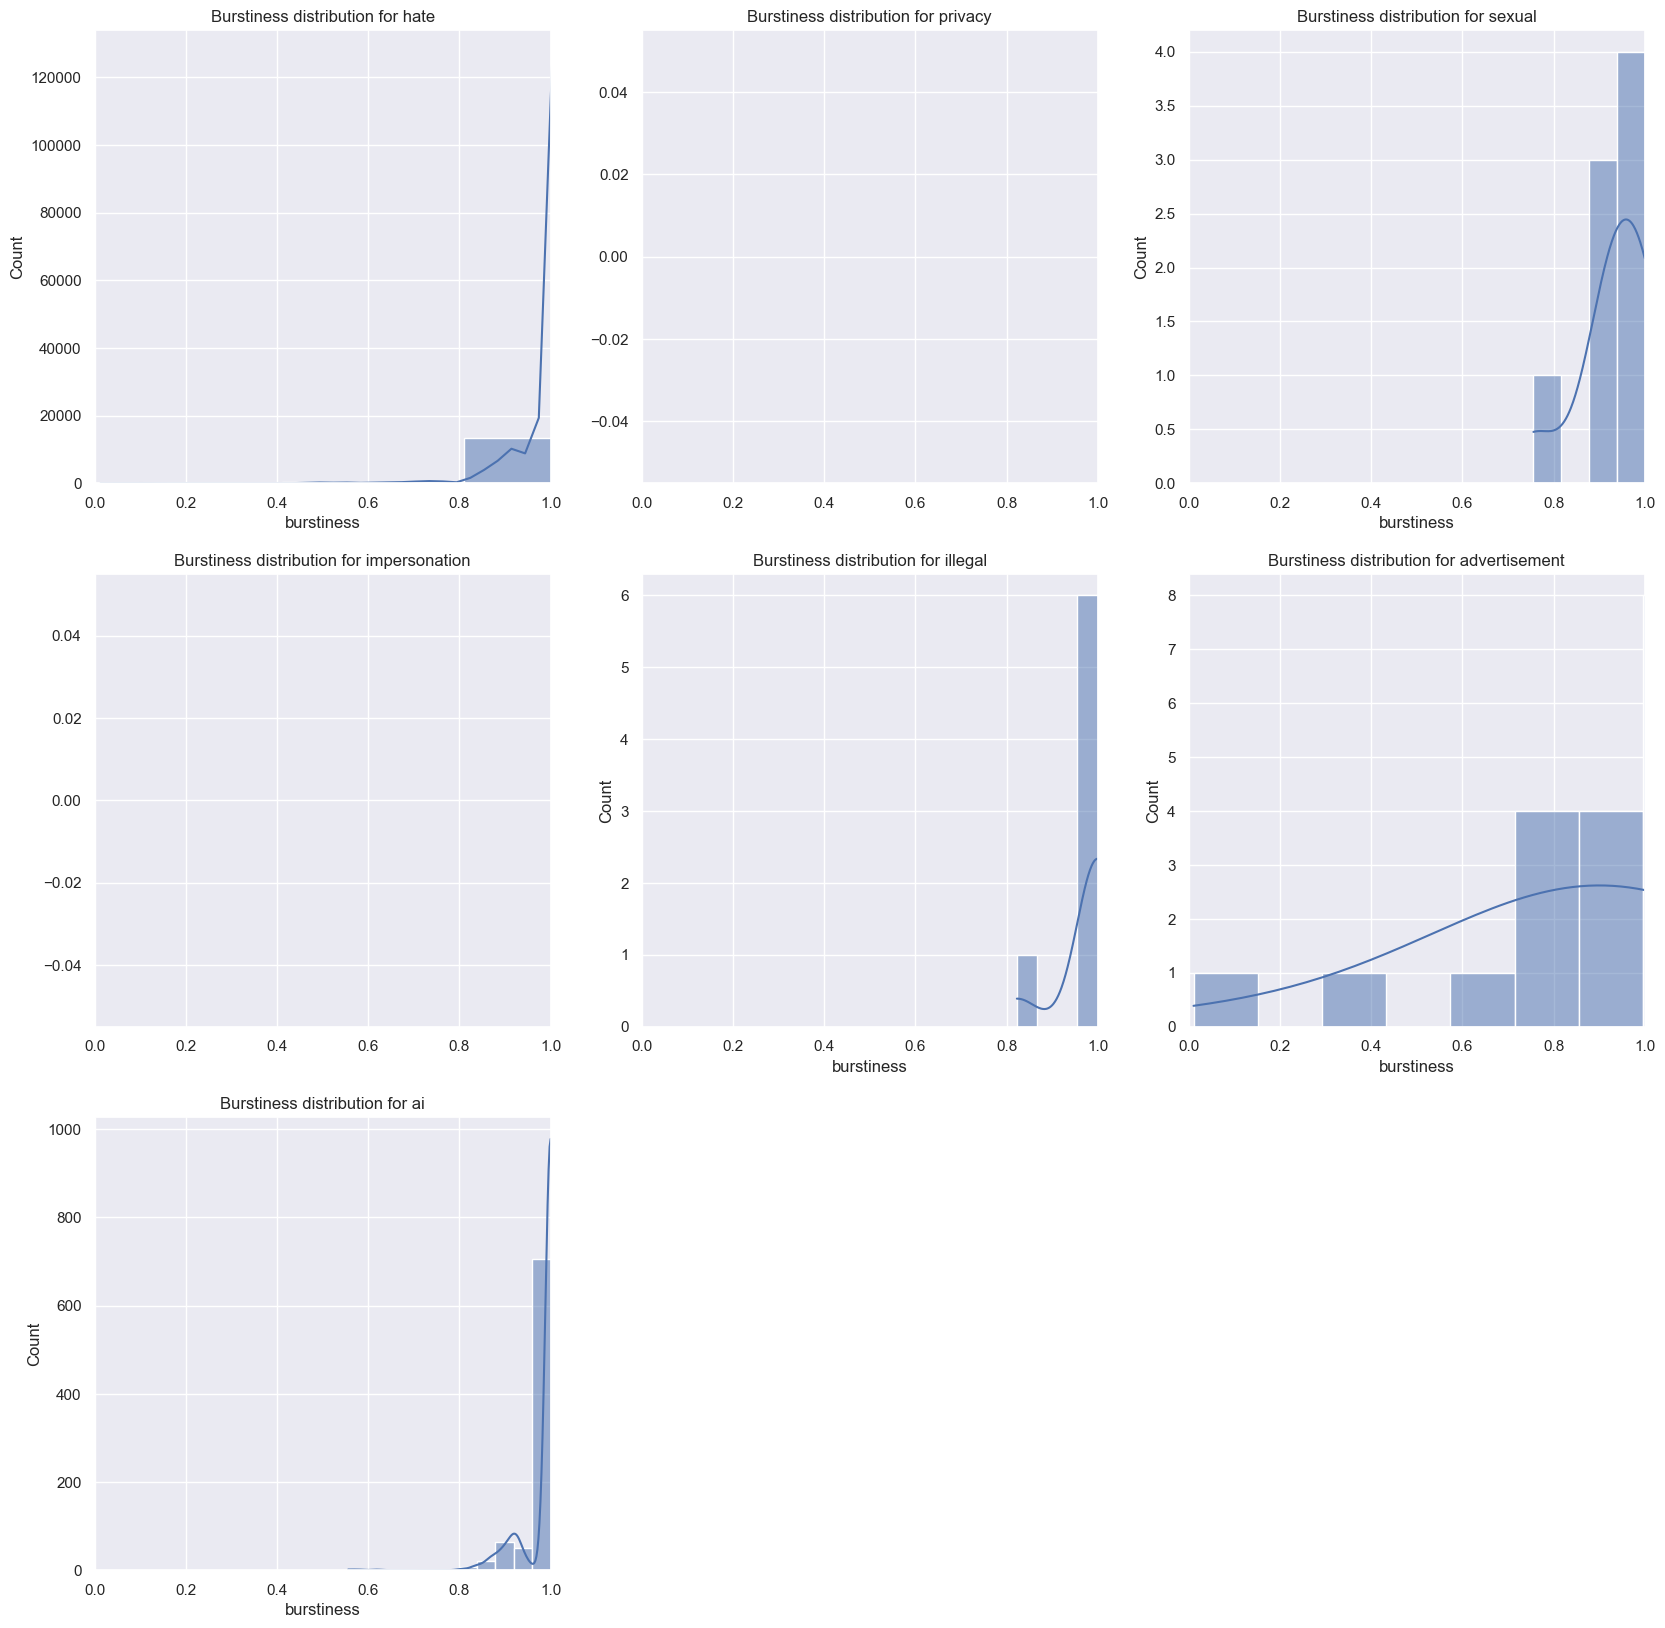

In [77]:
# plotting distribution of burstiness for unigram model for each target

fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for i, target in enumerate(TARGET_VARS):
    sns.histplot(perplexity_unigram_results_df_merged[perplexity_unigram_results_df_merged[target] == 1]["burstiness"], kde=True, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_xlim(0, 1)
    axes[i//3, i%3].set_title(f"Burstiness distribution for {target}")
axes[2, 1].set_visible(False)
axes[2, 2].set_visible(False)
